# Fraud Detection in Card Portfolio Transactions

## Abstract

This project presents a comprehensive fraud detection framework for identifying suspicious activity within a card transactions portfolio. Developed for a consulting context, it combines both domain expertise and data science rigor to address the practical challenge of minimizing financial fraud while maintaining operational efficiency.

The analysis begins with a structured exploratory assessment of transaction-level data, highlighting key variables such as transaction amount, card presence, e-commerce activity, 3D Secure usage, and wallet types. A set of interpretable, business-driven fraud rules is then designed based on industry heuristics, forming the baseline for a rule-based fraud alert system.

To improve detection performance, a logistic regression model is developed using carefully selected features, offering a balance between predictive power and interpretability. Model outputs are benchmarked against the rule-based system using a set of custom KPIs relevant to the banking sector — including detection rate, false positive rate, and traditional classification metrics.

Throughout the notebook, special attention is given to interpretability, business relevance, and actionable insights. The dual-model approach not only demonstrates technical competence but also reflects a strategic consulting mindset: combining expert knowledge with data-driven optimization to create solutions that are both effective and trusted by business stakeholders.

## Imports

In [ ]:
import numpy as np
import pandas as pd

import scipy as sp
from scipy import stats

import matplotlib.pyplot as plt
import seaborn as sns

from src.LoggerClass import FraudRuleLogger

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score, precision_recall_curve
import warnings
from sklearn.exceptions import ConvergenceWarning

import streamlit as st

## View Data

In [ ]:
# Load Dataset
df = pd.read_csv("data_processed.csv")

In [178]:
# View Data
df.head()

,drn,customer_id,masked_pan,datetime,card_present,ecommerce,3ds,wallet,country,amount,...,hour,weekday,day,month,total_id,number_of_abroad_trx,region,is_wallet,number_of_wallet_trx,time_diff
0,TXN0040287,CUST000000,**** **** **** 1226,2024-04-26 02:55:26,1,0,0,NaN,IE,194.76,...,2,Friday,26,4,CUST000000 - **** **** **** 1226,1,Europe,0,0,NaN
1,TXN0060050,CUST000000,**** **** **** 2369,2024-03-13 14:41:50,1,0,0,NaN,IT,50.29,...,14,Wednesday,13,3,CUST000000 - **** **** **** 2369,1,Europe,0,0,NaN
2,TXN0068801,CUST000000,**** **** **** 4541,2023-12-26 22:46:59,0,1,0,NaN,BE,8.64,...,22,Tuesday,26,12,CUST000000 - **** **** **** 4541,1,Europe,0,0,NaN
3,TXN0044653,CUST000000,**** **** **** 8664,2024-03-13 17:17:04,0,1,0,NaN,PK,58.02,...,17,Wednesday,13,3,CUST000000 - **** **** **** 8664,1,Asia,0,0,NaN
4,TXN0031890,CUST000000,**** **** **** 8743,2024-03-14 03:02:38,1,0,0,NaN,BE,75.16,...,3,Thursday,14,3,CUST000000 - **** **** **** 8743,1,Europe,0,0,NaN


In [179]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 134560 entries, 0 to 134559
Data columns (total 23 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   drn                   134560 non-null  object 
 1   customer_id           134560 non-null  object 
 2   masked_pan            134560 non-null  object 
 3   datetime              134560 non-null  object 
 4   card_present          134560 non-null  int64  
 5   ecommerce             134560 non-null  int64  
 6   3ds                   134560 non-null  int64  
 7   wallet                46054 non-null   object 
 8   country               134560 non-null  object 
 9   amount                134560 non-null  float64
 10  card_type             134560 non-null  object 
 11  fraud_label           134560 non-null  int64  
 12  hour_range            134560 non-null  object 
 13  hour                  134560 non-null  int64  
 14  weekday               134560 non-null  object 
 15  

In [180]:
# Convert to datetime if not already
df['datetime'] = pd.to_datetime(df['datetime'])

## Rule Creation

__IMPORTANT 1:__ It might seem redundant, __but__ the following rules will overlap. We need to design, develop and implement a holistic solution.
If the fraudster bypass a rule and a security check, then another one of our rules will be able to stop the action immediately. In order to do that we need to have the rules to somewhat overlap. 

__IMPORTANT 2:__ During this section we create rules. These rules, when triggered, generate an alert that reaches the fraud officers of the bank. The fraud officers inspect the flaged/alerted transactions for fraud.

__IMPORTANT 3:__ Each rule is evaluated on TPs, TN, FPs and FNs. Based on these elements of the confusion matrix, we formulate 4 KPIs.

- FDR: Fraud Detection Rate
- ACR: Alert Conversion Rate
- FPR: False Positive Rate
- FACR: Fraud Amount Captured Rate

These KPIs where chosen due to being highly interpretable by bank officers, impactful and concise.

__IMPORTANT 4:__ We use these KPIs in order to measure the impact not just of the rules but of the models as well. We prefer models that reach the belowmentioned benchmarks

| **KPI**                              | **Industry Benchmark**      |
|------------------------------------- |-----------------------------|
| **ACR** (Alert Conversion Rate)      | ≥ 2–5%                      |
| **FDR** (Fraud Detection Rate)       | ≥ 90–95%                    |
| **FPR** (False Positive Rate)        | ≤ 1–5%                      |
| **FACR** (Fraud Amount Captured Rate)| > 80% (desirable)           |

We will utilize the insights from the EDA section and new features created during the Feature Engineering to form Rules that catch fraud cases.

Each new rule will become a new column. (1 is fraud - 0 not fraud)

We also created a logger for each Rule we create to track Fraud Cases captured against the total fraud cases as well as the how the fraud rate changes through time.

In [181]:
logger = FraudRuleLogger()

The function __evaluate_and_log_fraud_rule__ will help us enter each trial into the logger.

In [182]:
def evaluate_and_log_fraud_rule(df, logger, rule_name, rule_filter, verbose=False):
    """
    Evaluates fraud metrics for a rule, logs them, and optionally prints summary.
    
    Parameters:
        df (pd.DataFrame): Your main dataset
        logger (FraudRuleLogger): The logger instance
        rule_name (str): Name of the rule
        rule_filter (Series[bool]): Boolean filter for the rule
        verbose (bool): If True, prints the summary

    Returns:
        dict: Fraud summary for this rule
    """
    # Filter the data
    filtered_df = df[rule_filter]
    
    # Calculate metrics
    total_transactions = filtered_df.shape[0]
    total_fraud_count = filtered_df['fraud_label'].sum()
    fraud_rate = (total_fraud_count / total_transactions) * 100 if total_transactions > 0 else 0
    fraud_amount = filtered_df[filtered_df['fraud_label'] == 1]['amount'].sum()
    
    # Log the rule
    logger.log_rule(df, rule_name, rule_filter)
    
    # Prepare summary
    summary = {
        'rule_name': rule_name,
        'total_fraud_count': total_fraud_count,
        'total_transactions': total_transactions,
        'fraud_rate (%)': round(fraud_rate, 2),
        'fraud_amount_saved': round(fraud_amount, 2)
    }
    
    if verbose:
        print(summary)
    
    return summary

### First Transaction Abroad

In [183]:
def plot_fraud_analysis(df, logger, rule_name, filter_condition_fn, num_trx=1, verbose=False):
    amounts = []
    fraud_rates = []
    fraud_savings = []

    for amnt in range(50, 1000, 10):
        condition = filter_condition_fn(df, num_trx, amnt)
        summary = evaluate_and_log_fraud_rule(
            df,
            logger,
            rule_name,
            condition,
            verbose=verbose
        )
        amounts.append(amnt)
        fraud_rates.append(summary['fraud_rate (%)'])
        fraud_savings.append(summary['fraud_amount_saved'])

    # Plotting
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(amounts, fraud_rates, marker='o', linestyle='-')
    plt.title(f"Fraud Rate vs. Amount Threshold ({rule_name})")
    plt.xlabel("Amount Threshold")
    plt.ylabel("Fraud Rate (%)")
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(amounts, fraud_savings, marker='x', linestyle='-', color='green')
    plt.title(f"Fraud Amount Saved vs. Amount Threshold ({rule_name})")
    plt.xlabel("Amount Threshold")
    plt.ylabel("Fraud Amount Saved")
    plt.grid(True)

    plt.tight_layout()
    plt.show()


In [184]:
def abroad_trx(df, num_trx, amnt):
    return (df['number_of_abroad_trx'] == num_trx) & (df['amount'] > amnt)

def abroad_nonsec_ecom(df, num_trx, amnt):
    return (
        (df['number_of_abroad_trx'] == num_trx) &
        (df['amount'] > amnt) &
        (df['3ds'] == 0) &
        (df['ecommerce'] == 1)
    )

def abroad_nonsec_ecom_region(df, num_trx, amnt):
    return (
        (df['number_of_abroad_trx'] == num_trx) &
        (df['amount'] > amnt) &
        (df['3ds'] == 0) &
        (df['ecommerce'] == 1) &
        (df['region'].isin(["Asia"]))
    )

def abroad_nonsec_ecom_hourrange(df, num_trx, amnt):
    return (
        (df['number_of_abroad_trx'] == num_trx) &
        (df['amount'] > amnt) &
        (df['3ds'] == 0) &
        (df['ecommerce'] == 1) &
        (df['hour_range'].isin(["00:00–04:00", "04:00–08:00", "08:00–12:00"]))
    )

def abroad_nonsec_ecom_card_type(df, num_trx, amnt):
    return (
        (df['number_of_abroad_trx'] == num_trx) &
        (df['amount'] > amnt) &
        (df['3ds'] == 0) &
        (df['ecommerce'] == 1) &
        (df['card_type'].isin(['credit', 'prepaid']))
    )

def abroad_nonsec_ecom_wallet(df, num_trx, amnt):
    return (
        (df['number_of_abroad_trx'] == num_trx) &
        (df['amount'] > amnt) &
        (df['3ds'] == 0) &
        (df['ecommerce'] == 1) &
        (df['is_wallet'] == 1)
    )

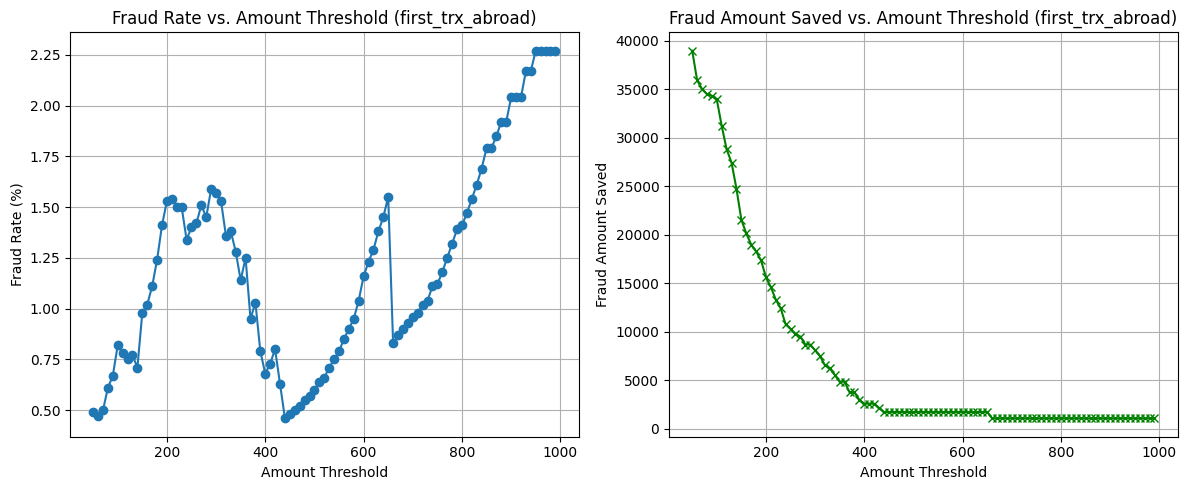

In [185]:
plot_fraud_analysis(df, logger, "first_trx_abroad", abroad_trx, num_trx=1)

From the above two diagrams we can notice that if the amount spent during the first transaction abroad is circa 200EUR we have a fraud rate of 1.5%.

This amount threshold allows us to save circa 15000EUR in fraudulent transactions.

The purpose is to save money from fradulent transactions while preserving high fraud capture rates.

__Current Thresholds Proposed:__ __Amount > 200 EUR__ __&__ __number_of_abroad_trx = 1__

During the EDA section we unveiled that ecommerce and specifically non-3ds Secure transactions are much more susceptible to fraud.

__Next:__ We explore how a non secure, ecommerce transaction abroad modifies the above mentioned thresholds and if it improves fraud rate and captured amount

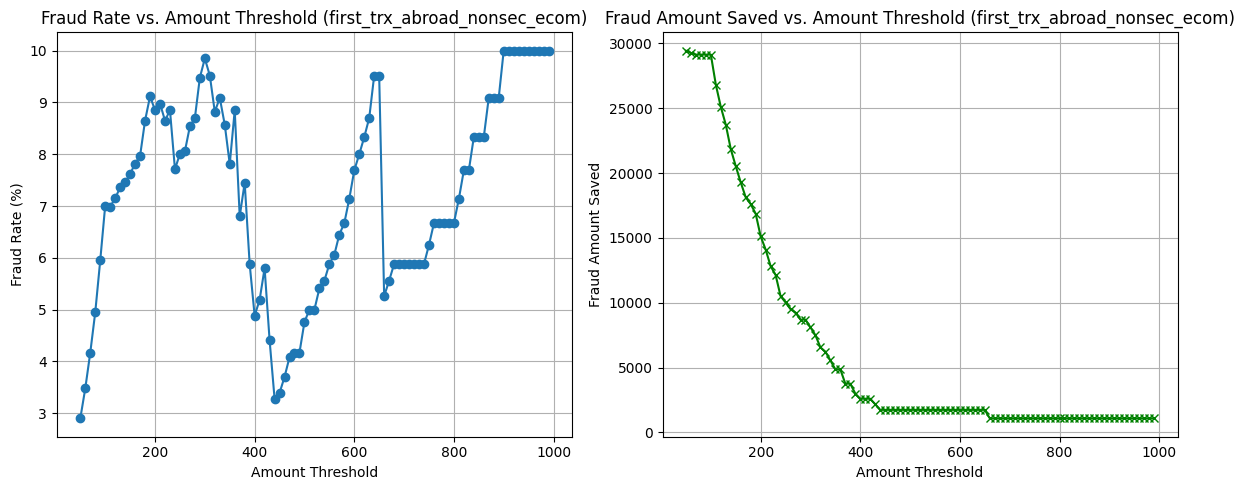

In [186]:
plot_fraud_analysis(df, logger, "first_trx_abroad_nonsec_ecom", abroad_nonsec_ecom, num_trx=1)

Exploring a first abroad, non secure, ecommerce transaction boosts both the the fraud amount captured as well as the fraud rate.

Specifically we achieve a 10% fraud rate and capture 7500EUR circa if we choose an amount threshold above 300EUR circa. If we choose a lower amount threshold, specifically 100EUR circa, we observe a lower fraud rate 7% but we capture almost 30000EUR which is about 60% of the fraud amount.

We will build upont the current results and try to improve our current rule by adding additional conditions to see if the results get better or worse.

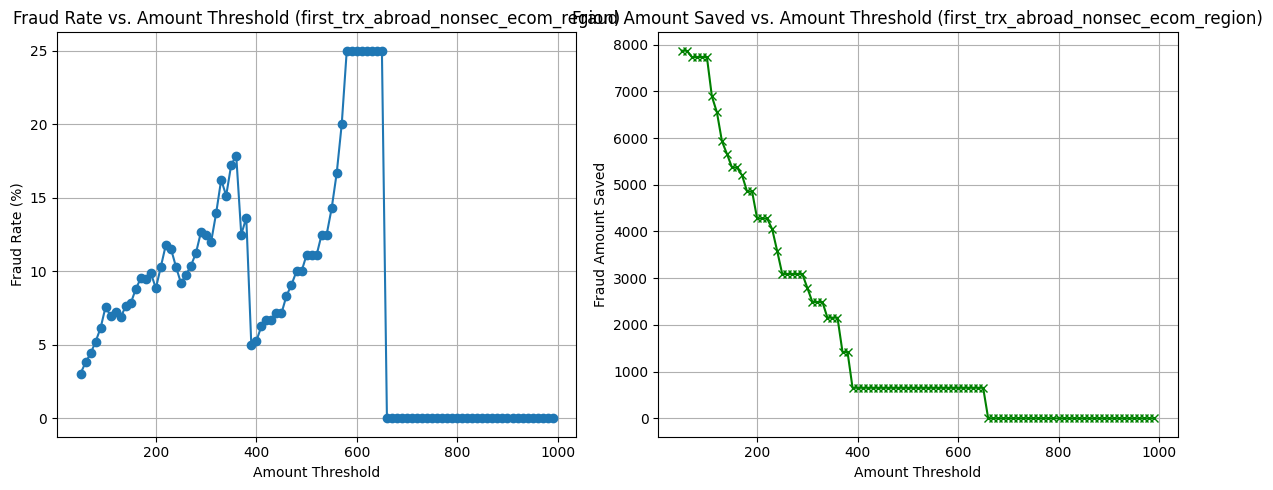

In [187]:
plot_fraud_analysis(df, logger, "first_trx_abroad_nonsec_ecom_region", abroad_nonsec_ecom_region, num_trx=1)

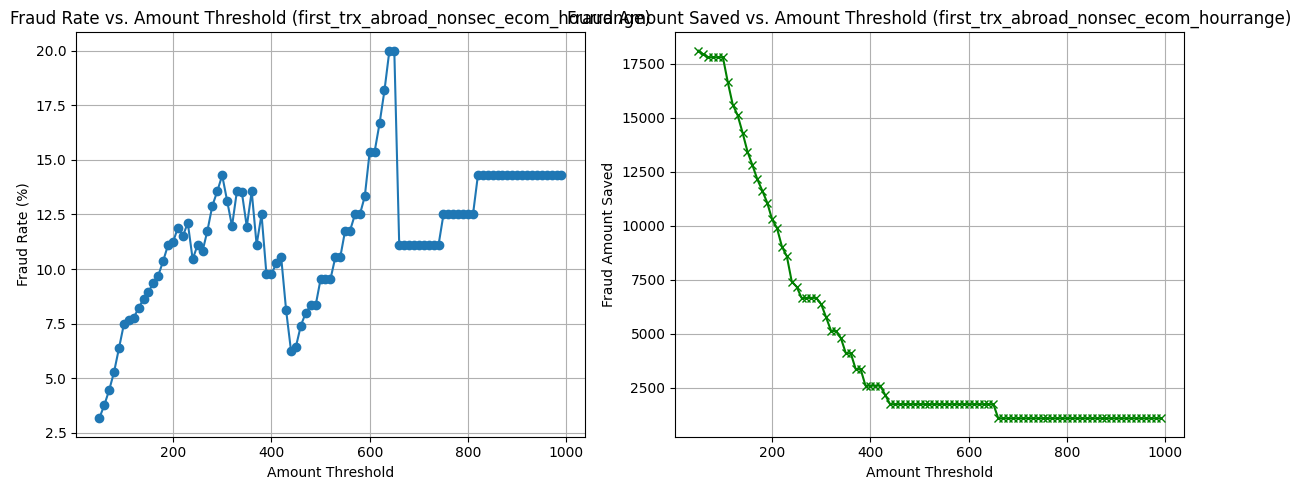

In [188]:
plot_fraud_analysis(df, logger, "first_trx_abroad_nonsec_ecom_hourrange", abroad_nonsec_ecom_hourrange, num_trx=1)

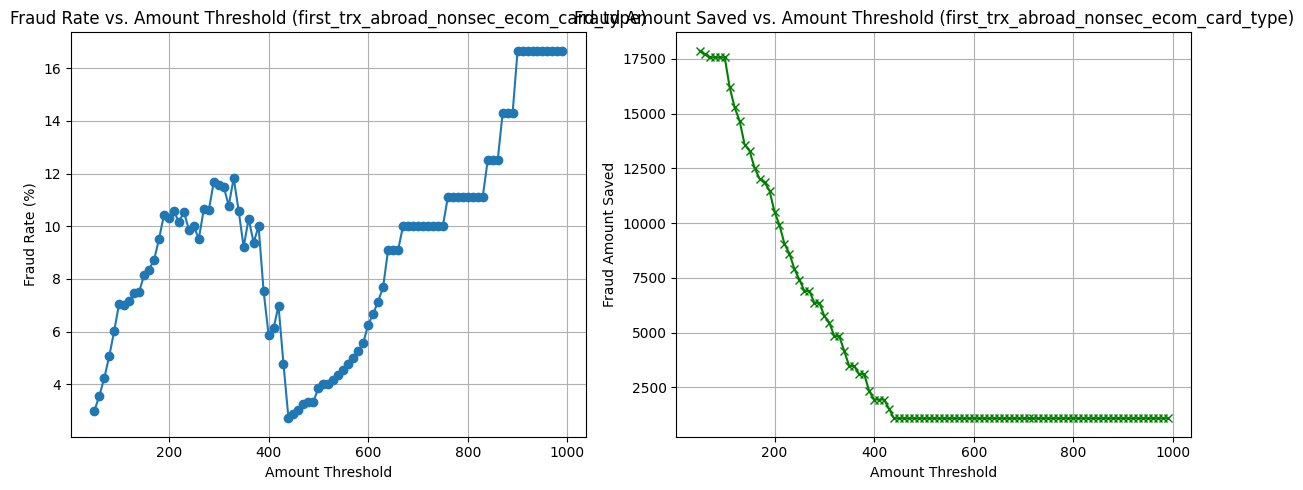

In [189]:
plot_fraud_analysis(df, logger, "first_trx_abroad_nonsec_ecom_card_type", abroad_nonsec_ecom_card_type, num_trx=1)

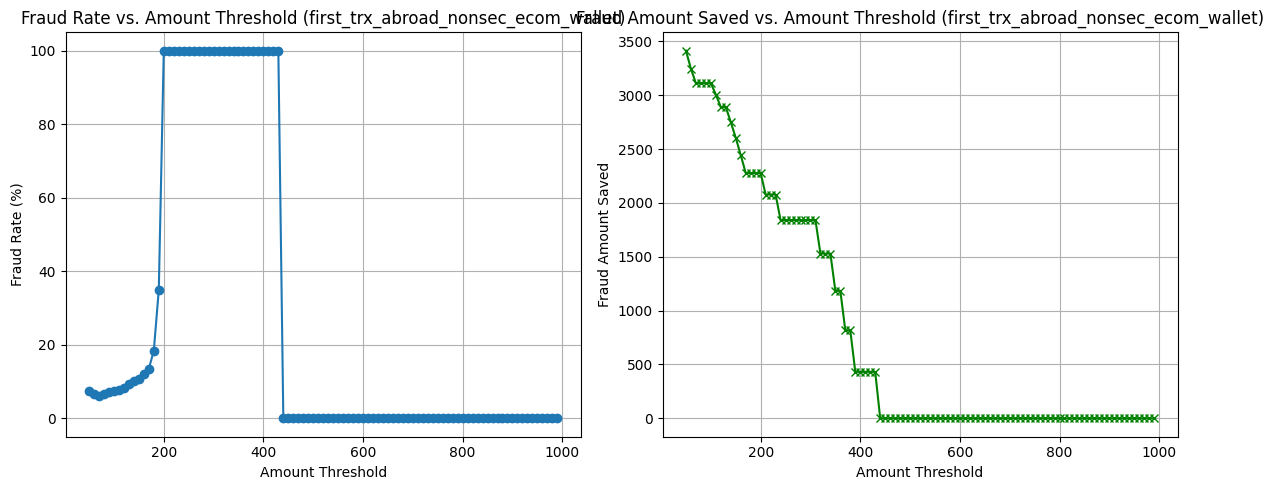

In [190]:
plot_fraud_analysis(df, logger, "first_trx_abroad_nonsec_ecom_wallet", abroad_nonsec_ecom_wallet, num_trx=1)

No significant increase occurs in fraud rate that also shows benefit for the fraud amount captured by our current rule for the following:
- region implementation,
- hour_range implementation,
- card_type implementation.

We do however discover that in our dataset first abroad non-secure ecommerce wallet transactions between 200 and 400 EUR are fraud cases. This seems like an outlier or bug in our system and needs better data monitoring because under PSD2 there is no reason for payments to not be monitored in this range especially because for amounts larger than 420-430 EUR any fraud occurs.

We access the logger's logs to identify the best cases and decide about the thresholds.

In [191]:
log_df = logger.get_logs()
results = log_df[(log_df['fraud_amount_saved'] > 25000) & (log_df['rule_name'] == 'first_trx_abroad_nonsec_ecom')]
results

,trial_number,rule_name,total_fraud_count,total_transactions,fraud_rate,fraud_amount_saved
95,96,first_trx_abroad_nonsec_ecom,157,5422,2.90,29425
96,97,first_trx_abroad_nonsec_ecom,154,4429,3.48,29257
97,98,first_trx_abroad_nonsec_ecom,152,3642,4.17,29124
98,99,first_trx_abroad_nonsec_ecom,152,3068,4.95,29124
99,100,first_trx_abroad_nonsec_ecom,152,2556,5.95,29124
100,101,first_trx_abroad_nonsec_ecom,152,2169,7.01,29124
101,102,first_trx_abroad_nonsec_ecom,130,1859,6.99,26810
102,103,first_trx_abroad_nonsec_ecom,115,1609,7.15,25093


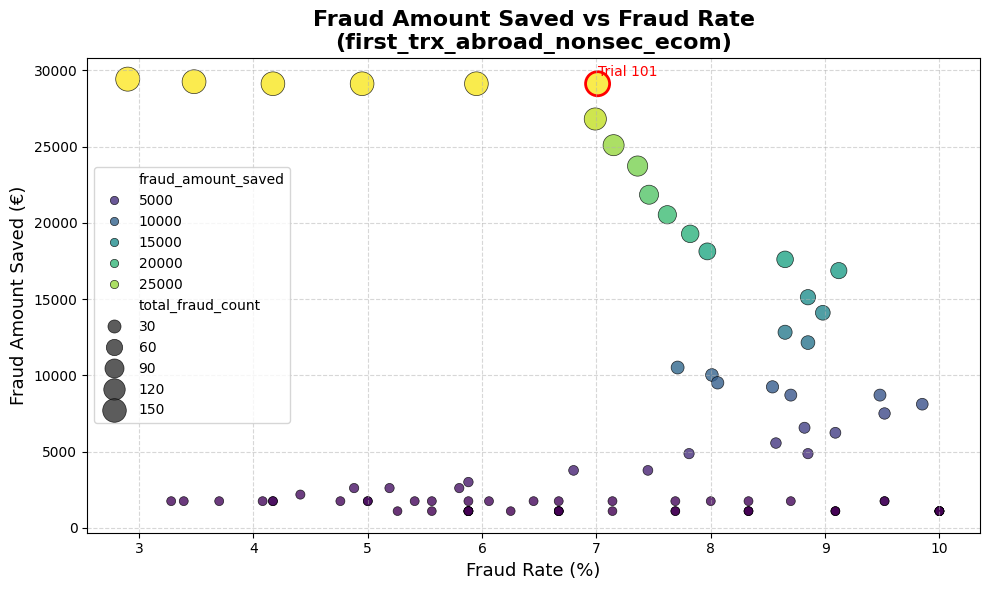

In [192]:
# Filter the DataFrame
filtered_log_df = log_df[log_df['rule_name'] == 'first_trx_abroad_nonsec_ecom']

# Create the scatterplot
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=filtered_log_df,
    x='fraud_rate',
    y='fraud_amount_saved',
    size='total_fraud_count',
    hue='fraud_amount_saved',
    palette='viridis',
    sizes=(40, 300),
    alpha=0.8,
    edgecolor='black',
    linewidth=0.5
)

# 
highlight = filtered_log_df[
    (filtered_log_df['fraud_rate'].between(6.8, 7.2)) &
    (filtered_log_df['fraud_amount_saved'].between(29000, 30000))
]

plt.scatter(
    highlight['fraud_rate'],
    highlight['fraud_amount_saved'],
    s=300,
    facecolors='none',
    edgecolors='red',
    linewidths=2,
)

# Optional annotation
for _, row in highlight.iterrows():
    plt.text(row['fraud_rate'] + 0.002, row['fraud_amount_saved'] + 500,
             f"Trial {row['trial_number']}", fontsize=10, color='red')

# Improve axes and title
plt.title("Fraud Amount Saved vs Fraud Rate\n(first_trx_abroad_nonsec_ecom)", fontsize=16, weight='bold')
plt.xlabel("Fraud Rate (%)", fontsize=13)
plt.ylabel("Fraud Amount Saved (€)", fontsize=13)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(loc="best", frameon=True)
plt.tight_layout()
plt.show()



The highlighted point in the graph showcases the best combination of thresholds. 

For this specific rule i.e. __first_trx_abroad_nonsec_ecom__ the thresholds chosen are the following:

- __number_of_abroad_trx = 1 &__ 
- __Amount > 100EUR &__
- __ecommerce = 1 &__
- __3ds = 0__

When choosing these thresholds we get the following results:
1. Number of perimeter transactions -> 2169
2. Total frauds inside the perimeter -> 152
3. Fraud Rate -> 7.01%
4. Fraud Amount -> 29.124EUR (about 60% of overall fraud amount)

In [193]:
df['first_trx_abroad_nonsec_ecom'] = np.where(
    (df['number_of_abroad_trx'] == 1) &
    (df['amount'] > 100) &
    (df['ecommerce'] == 1) &
    (df['3ds'] == 0),
    1,
    0
)

In [194]:
# Define the alert condition
alert_condition = (
    (df['number_of_abroad_trx'] == 1) &
    (df['amount'] > 100) &
    (df['ecommerce'] == 1) &
    (df['3ds'] == 0)
)

# Confusion Matrix Components
tps = df[alert_condition & (df['fraud_label'] == 1)].shape[0]
fps = df[alert_condition & (df['fraud_label'] == 0)].shape[0]
fns = df[~alert_condition & (df['fraud_label'] == 1)].shape[0]
tns = df[~alert_condition & (df['fraud_label'] == 0)].shape[0]

# Optional: Print nicely
print("Confusion Matrix for Rule-Based Alert:")
print(f"TP: {tps}")
print(f"FP: {fps}")
print(f"FN: {fns}")
print(f"TN: {tns}\n")

Confusion Matrix for Rule-Based Alert:
TP: 152
FP: 2017
FN: 271
TN: 132120



|confusion Matrix|Value|
|----------------|-----|
|TP|152|
|FP|2017|
|FN|271|
|TN|132120|

### High Risk Regions (Fraud & Fraud Amount)

Some countries are closely monitored since fraudsters can easily bypass subpar security and make large transactions. This rule splits into two subrules:
- Countries that we have observed to have moderate or average fraud rates but very high fraud amounts and
- Countries that we have observed to have moderate fraud amounts but high fraud rates.

During our EDA process and the Segmentation Analysis Section we observed the abomentioned characteristics and concluded that the Asia region is is the first group.
Specifically:
- The Asia region includes the following countries: 
    - China (CN), India (IN), Pakistan (PK), Japan (JP), Singapore (SG).
    - These countries have average fraud rate ranging from (0.21% to 0.37%) and 68 fraud cases (~15% of the total fraud population) but 
    - account for about 21% of the total fraud amount with a total of 9737.7EUR 

Also the EDA process unveiled that US has high fraud rates thoug not as high fraud amounts.
Specifically USA has the following characteristics:
- the fraud rate for the US is almost 1% and account for 17% of the total fraud population with 74 fraud cases
- the fraud amount for these 74 fraud cases is about 6000EUR which is about 13% of the total fraud amount we need to capture.

In [195]:
df_amount = df[df['fraud_label'] == 1]['amount'].sum()
df_fraud_cases = df[df['fraud_label'] == 1].fraud_label.count()
df_fraud_cases_asia = df[(df['fraud_label'] == 1) & (df['region'] == 'Asia')].fraud_label.count()
df_asia_amount = df[(df['fraud_label'] == 1) & (df['region'] == 'Asia')]['amount'].sum()
print(df_asia_amount, df_amount, df_asia_amount/df_amount)
print(df_fraud_cases_asia, df_fraud_cases,df_fraud_cases_asia/df_fraud_cases)

9737.7 46176.240000000005 0.21088118045124504
68 423 0.1607565011820331


In [196]:
df_amount = df[df['fraud_label'] == 1]['amount'].sum()
df_fraud_cases = df[df['fraud_label'] == 1].fraud_label.count()
df_fraud_cases_us = df[(df['fraud_label'] == 1) & (df['region'] == 'North America')].fraud_label.count()
df_us_amount = df[(df['fraud_label'] == 1) & (df['region'] == 'North America')]['amount'].sum()
print(df_us_amount, df_amount, df_us_amount/df_amount)
print(df_fraud_cases_us, df_fraud_cases,df_fraud_cases_us/df_fraud_cases)

5985.82 46176.240000000005 0.12962987025361958
74 423 0.17494089834515367


In [197]:
def plot_fraud_analysis_high_risk_country(df, logger, rule_name, filter_condition_fn, verbose=False):
    amounts = []
    fraud_rates = []
    fraud_savings = []

    for amnt in range(50, 1000, 10):
        condition = filter_condition_fn(df, amnt)
        summary = evaluate_and_log_fraud_rule(
            df,
            logger,
            rule_name,
            condition,
            verbose=verbose
        )
        amounts.append(amnt)
        fraud_rates.append(summary['fraud_rate (%)'])
        fraud_savings.append(summary['fraud_amount_saved'])

    # Plotting
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(amounts, fraud_rates, marker='o', linestyle='-')
    plt.title(f"Fraud Rate vs. Amount Threshold ({rule_name})")
    plt.xlabel("Amount Threshold")
    plt.ylabel("Fraud Rate (%)")
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(amounts, fraud_savings, marker='x', linestyle='-', color='green')
    plt.title(f"Fraud Amount Saved vs. Amount Threshold ({rule_name})")
    plt.xlabel("Amount Threshold")
    plt.ylabel("Fraud Amount Saved")
    plt.grid(True)

    plt.tight_layout()
    plt.show()

In [198]:
def high_risk_country_trx(df, amnt):
    return (df['region'] == 'Asia') & (df['amount'] > amnt)

def high_risk_country_trx_nonsec(df, amnt):
    return (
        (df['region'] == 'Asia') &
        (df['amount'] > amnt) &
        (df['3ds'] == 0)
    )

def high_risk_country_trx_nonwallet(df, amnt):
    return (
        (df['region'] == 'Asia') &
        (df['amount'] > amnt) &
        (df['is_wallet'] == 0)
    )

def high_risk_country_trx_nonsec_nonwallet(df, amnt):
    return (
        (df['region'] == 'Asia') &
        (df['amount'] > amnt) &
        (df['3ds'] == 0) &
        (df['is_wallet'] == 0)
    )

def high_risk_country_trx_nonwallet_card_type(df, amnt):
    return (
        (df['region'] == 'Asia') &
        (df['amount'] > amnt) &
        (df['card_type'].isin(['prepaid', 'credit'])) &
        (df['is_wallet'] == 0)
    )

def high_risk_country_trx_nonwallet_hour_range(df, amnt):
    return (
        (df['region'] == 'Asia') &
        (df['amount'] > amnt) &
        (df['hour_range'].isin(["04:00–08:00", "08:00–12:00","16:00–20:00"])) &
        (df['is_wallet'] == 0)
    )


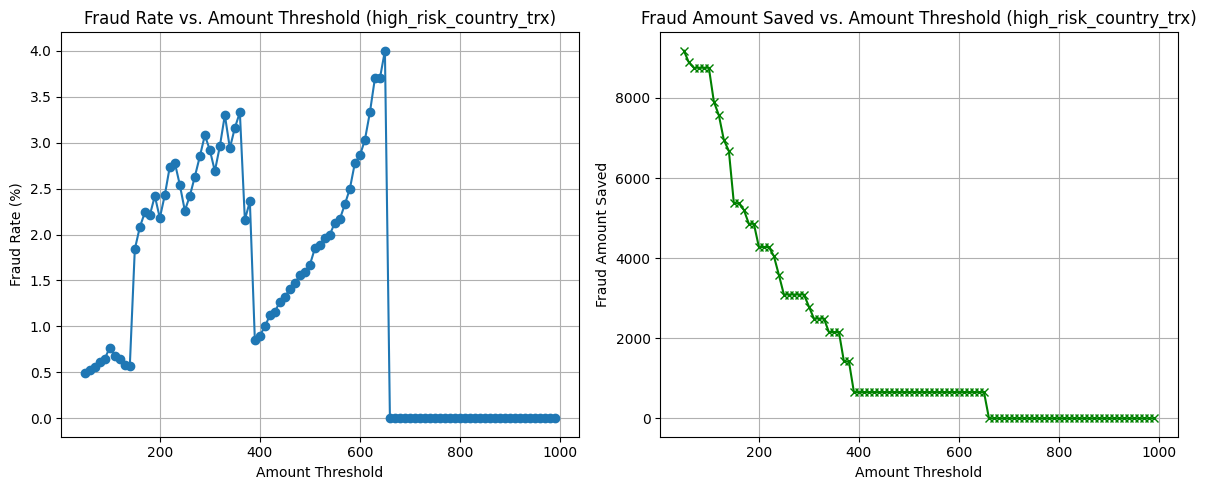

In [199]:
plot_fraud_analysis_high_risk_country(df, logger, "high_risk_country_trx", high_risk_country_trx)

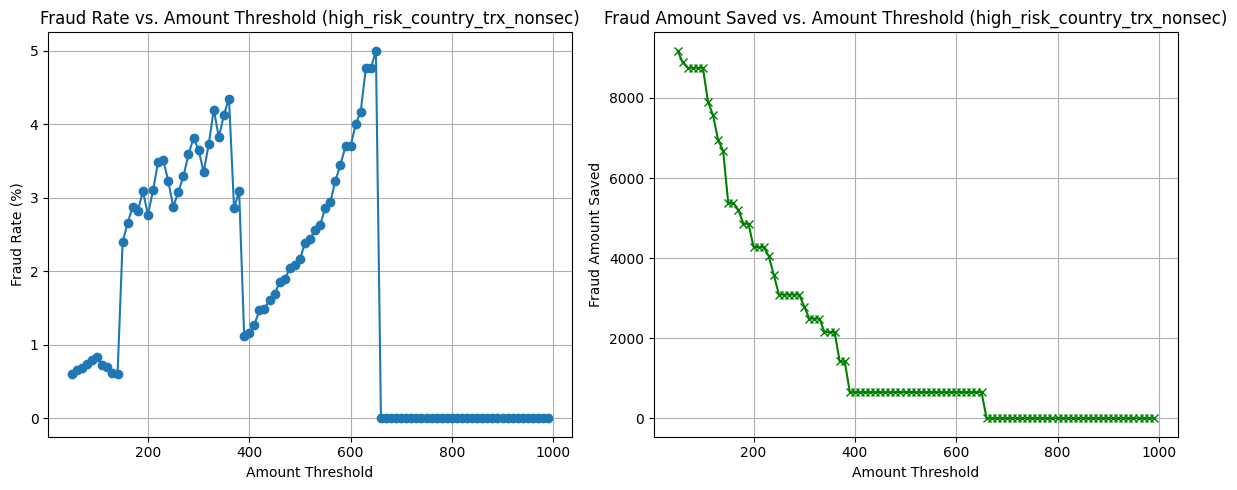

In [200]:
plot_fraud_analysis_high_risk_country(df, logger, "high_risk_country_trx_nonsec", high_risk_country_trx_nonsec)

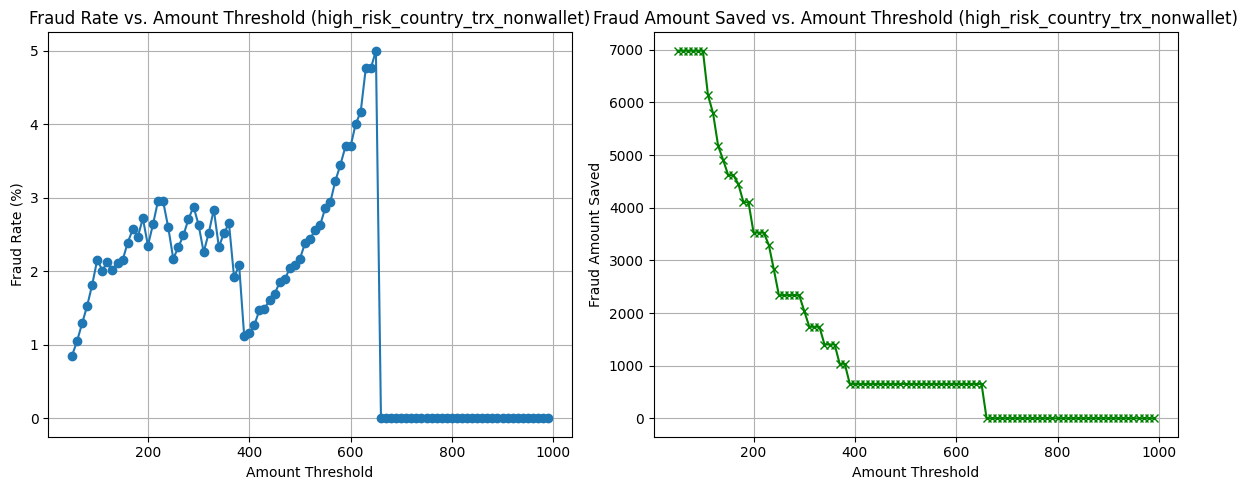

In [201]:
plot_fraud_analysis_high_risk_country(df, logger, "high_risk_country_trx_nonwallet", high_risk_country_trx_nonwallet)

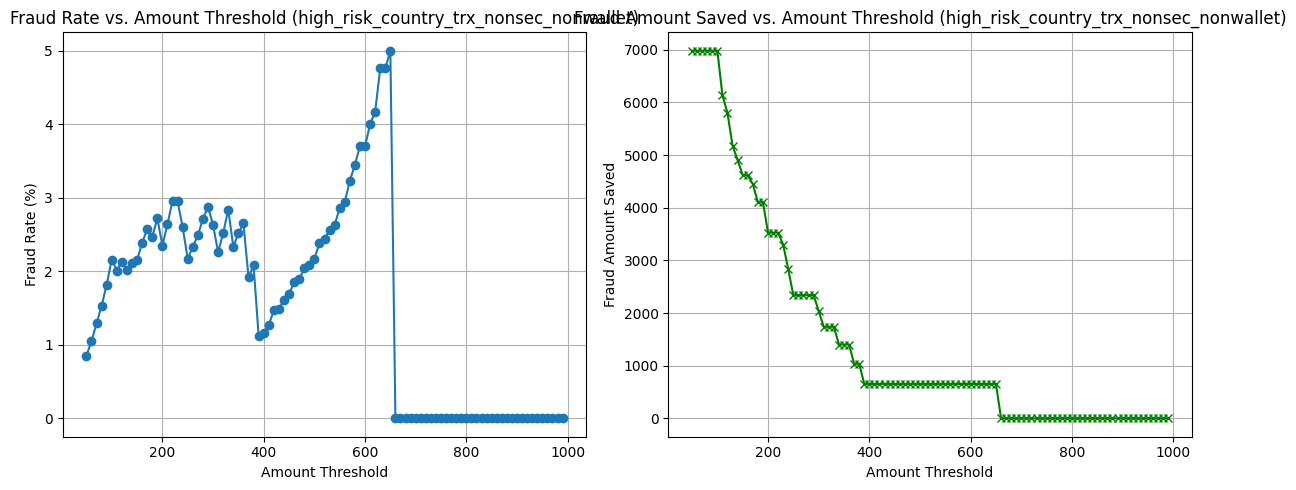

In [202]:
plot_fraud_analysis_high_risk_country(df, logger, "high_risk_country_trx_nonsec_nonwallet", high_risk_country_trx_nonsec_nonwallet)

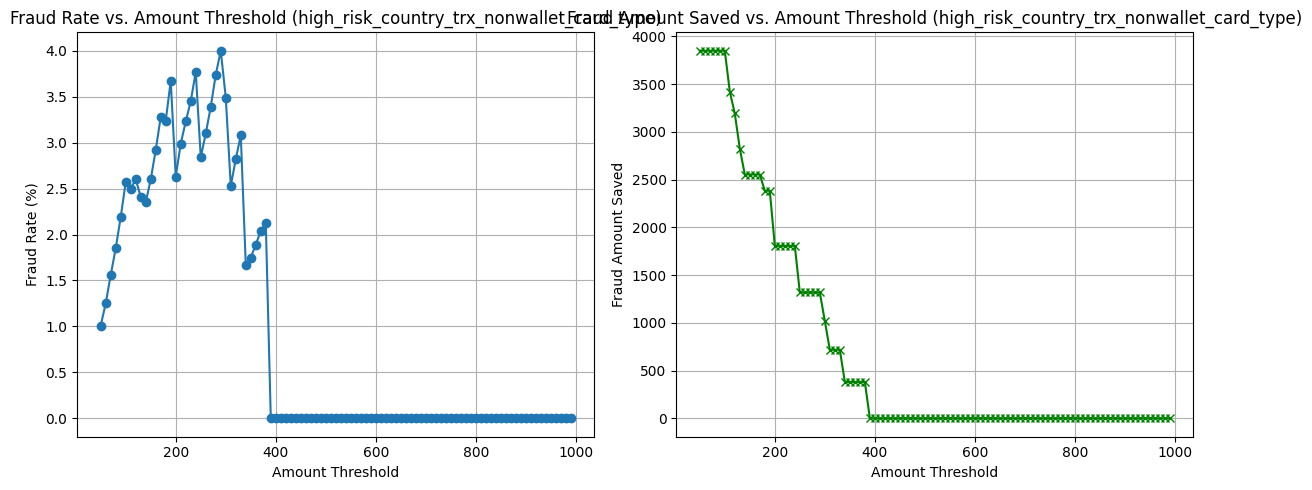

In [203]:
plot_fraud_analysis_high_risk_country(df, logger, "high_risk_country_trx_nonwallet_card_type", high_risk_country_trx_nonwallet_card_type)

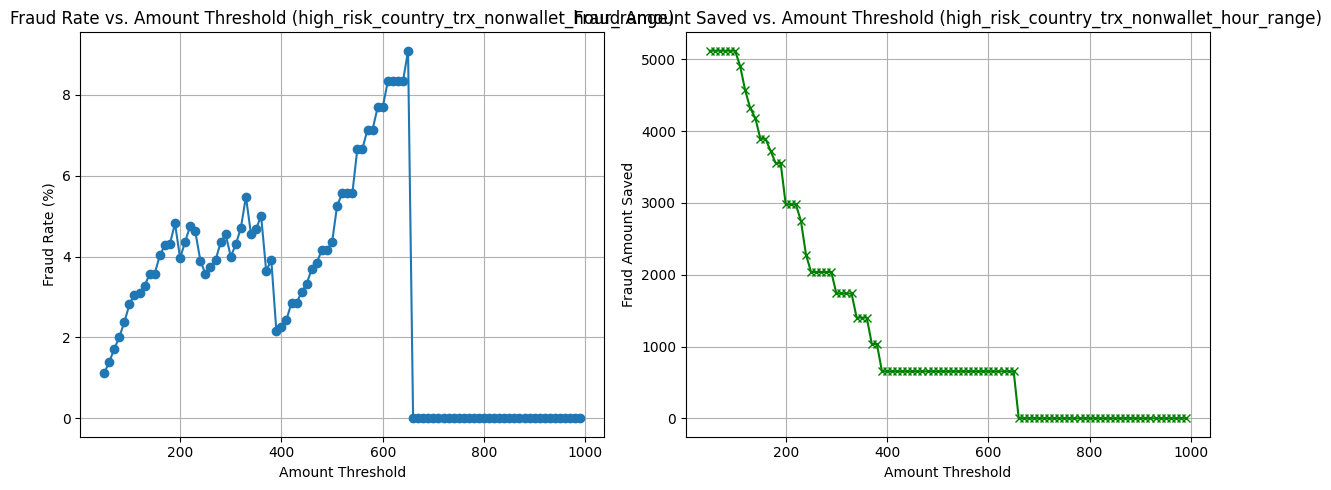

In [204]:
plot_fraud_analysis_high_risk_country(df, logger, "high_risk_country_trx_nonwallet_hour_range", high_risk_country_trx_nonwallet_hour_range)

In [205]:
log_df = logger.get_logs()
results = log_df[(log_df['fraud_amount_saved'] > 6000) & (log_df['rule_name'] == 'high_risk_country_trx_nonsec_nonwallet')]
results

,trial_number,rule_name,total_fraud_count,total_transactions,fraud_rate,fraud_amount_saved
855,856,high_risk_country_trx_nonsec_nonwallet,37,4365,0.85,6983
856,857,high_risk_country_trx_nonsec_nonwallet,37,3514,1.05,6983
857,858,high_risk_country_trx_nonsec_nonwallet,37,2866,1.29,6983
858,859,high_risk_country_trx_nonsec_nonwallet,37,2412,1.53,6983
859,860,high_risk_country_trx_nonsec_nonwallet,37,2030,1.82,6983
860,861,high_risk_country_trx_nonsec_nonwallet,37,1716,2.16,6983
861,862,high_risk_country_trx_nonsec_nonwallet,29,1444,2.01,6137


In the above tested iterations of the first group of the rule, we notice that a non-secure, non-wallet transaction to Asia yields the appropriate results. Specifically we flag about 1716 suspicious transactions as suspicious (~ 9 transactions pe day) and capture about 37 fraud cases and about 7000EUR.

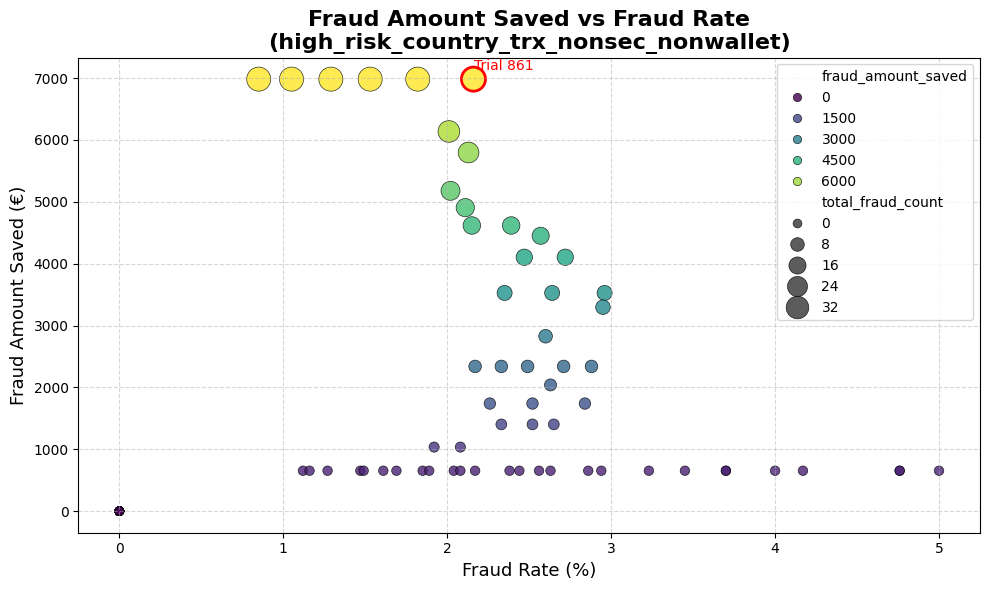

In [206]:
# Filter the DataFrame
filtered_log_df = log_df[log_df['rule_name'] == 'high_risk_country_trx_nonsec_nonwallet']

# Create the scatterplot
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=filtered_log_df,
    x='fraud_rate',
    y='fraud_amount_saved',
    size='total_fraud_count',
    hue='fraud_amount_saved',
    palette='viridis',
    sizes=(40, 300),
    alpha=0.8,
    edgecolor='black',
    linewidth=0.5
)

# 
highlight = filtered_log_df[
    (filtered_log_df['fraud_rate'].between(2.1, 2.2)) &
    (filtered_log_df['fraud_amount_saved'].between(6800, 7000))
]

plt.scatter(
    highlight['fraud_rate'],
    highlight['fraud_amount_saved'],
    s=300,
    facecolors='none',
    edgecolors='red',
    linewidths=2,
)

# Optional annotation
for _, row in highlight.iterrows():
    plt.text(row['fraud_rate'] + 0.002, row['fraud_amount_saved'] + 150,
             f"Trial {row['trial_number']}", fontsize=10, color='red')

# Improve axes and title
plt.title("Fraud Amount Saved vs Fraud Rate\n(high_risk_country_trx_nonsec_nonwallet)", fontsize=16, weight='bold')
plt.xlabel("Fraud Rate (%)", fontsize=13)
plt.ylabel("Fraud Amount Saved (€)", fontsize=13)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(loc="best", frameon=True)
plt.tight_layout()
plt.show()



In [207]:
df['high_risk_country_trx_nonsec_nonwallet'] = np.where(
        (df['region'] == 'Asia') &
        (df['amount'] > 100) &
        (df['3ds'] == 0) &
        (df['is_wallet'] == 0),
    1,
    0
)

In [208]:
# Define the alert condition
alert_condition = (
        (df['region'] == 'Asia') &
        (df['amount'] > 100) &
        (df['3ds'] == 0) &
        (df['is_wallet'] == 0)
)

# Confusion Matrix Components
tps = df[alert_condition & (df['fraud_label'] == 1)].shape[0]
fps = df[alert_condition & (df['fraud_label'] == 0)].shape[0]
fns = df[~alert_condition & (df['fraud_label'] == 1)].shape[0]
tns = df[~alert_condition & (df['fraud_label'] == 0)].shape[0]

# Optional: Print nicely
print("Confusion Matrix for Rule-Based Alert:")
print(f"TP: {tps}")
print(f"FP: {fps}")
print(f"FN: {fns}")
print(f"TN: {tns}\n")

Confusion Matrix for Rule-Based Alert:
TP: 37
FP: 1679
FN: 386
TN: 132458



__North America Region__

We will closely examine North America since it has unusual high fraud rate.

We will begin by examining CP vs CnP transactions specifically in North America

In [209]:
US_CP_df = df[(df['country'] == 'US') & (df['card_present'] == 1)]
US_CP_df_amount = US_CP_df[US_CP_df['fraud_label'] == 1]['amount'].sum()
US_CP_df_fraud_cases = US_CP_df[US_CP_df['fraud_label'] == 1].fraud_label.count()

US_CnP_df = df[(df['country'] == 'US') & (df['card_present'] == 0)]
US_CnP_df_amount = US_CnP_df[US_CnP_df['fraud_label'] == 1]['amount'].sum()
US_CnP_df_fraud_cases = US_CnP_df[US_CnP_df['fraud_label'] == 1].fraud_label.count()

print(f"The US CnP total fraud amount is: {round(US_CnP_df_amount,2)}. The total fraud cases are: {round(US_CnP_df_fraud_cases, 2)} and the avg fraud amount is {round(US_CnP_df_amount/US_CnP_df_fraud_cases,2)}")
print(f"The US CP total fraud amount is: {round(US_CP_df_amount,2)}. The total fraud cases are: {round(US_CP_df_fraud_cases, 2)} and the avg fraud amount is {round(US_CP_df_amount/US_CP_df_fraud_cases,2)}")

The US CnP total fraud amount is: 2820.98. The total fraud cases are: 26 and the avg fraud amount is 108.5
The US CP total fraud amount is: 3164.84. The total fraud cases are: 48 and the avg fraud amount is 65.93


The fraud amount is relatively the same between the classes with a slight edge on the CP transactions.

The average fraud amount though is much higher on the class of CnP transactions. 

This indicates that CnP and CP transactions need further investigation and rule tinkering.

In [210]:
def high_risk_us_wallet_trx(df, amnt = 100):
    return (df['region'] == 'North America') & (df['number_of_wallet_trx'] == 1) & (df['3ds'] == 0) & (df['amount'] < amnt)

def high_risk_us_nonsec_wallet_trx(df, amnt = 0):
    return (
        (df['region'] == 'North America') &
        (df['amount'] < amnt) &
        (df['is_wallet'] == 1) & 
        (df['3ds'] == 0) 
    )

def high_risk_us_cp_wallet_nonsec_trx(df, amnt = 0):
    return (
        (df['region'] == 'North America') &
        (df['amount'] < amnt) &
        (df['card_present'] == 1) &
        (df['is_wallet'] == 1) &
        (df['3ds'] == 0)
    )

def high_risk_us_cnp_trx(df, amnt = 0):
    return (df['region'] == 'North America') & (df['amount'] > amnt) & (df['card_present'] == 0)


def high_risk_us_cnp_wallet_trx(df, amnt = 0):
    return (
        (df['region'] == 'North America') &
        (df['amount'] > amnt) &
        (df['card_present'] == 0) &
        (df['is_wallet'] == 1)
    )

No sufficient rule was formulated for the case of North America.

For the rule regarding Asia base transactions we have the following results

|Confusion Matrix|Value|
|----------------|-----|
|TP|37|
|FP|1679|
|FN|386|
|TN|132458|

### First Wallet Transaction

We will examine Wallet Transactions more carefully. 

As we observed in the EDA section wallet transactions gather higher fraud rates then average.

Notice that wallet transaction gather 31% of total fraud amount and 52% of the total fraud cases.

We take inspiration from the first ecommerce non-secure transaction abroad.

In [211]:
first_wallet_cp_df = df[(df['number_of_wallet_trx'] == 1) & (df['card_present'] == 1)]
first_wallet_cp_df_amount = first_wallet_cp_df[first_wallet_cp_df['fraud_label'] == 1]['amount'].sum()
first_wallet_cp_df_fraud_cases = first_wallet_cp_df[first_wallet_cp_df['fraud_label'] == 1].fraud_label.count()
print(f"The first wallet total fraud amount is: {round(first_wallet_cp_df_amount,2)}. The total fraud cases are: {round(first_wallet_cp_df_fraud_cases, 2)} and the avg fraud amount is {round(first_wallet_cp_df_amount/first_wallet_cp_df_fraud_cases,2)}")

The first wallet total fraud amount is: 6934.35. The total fraud cases are: 120 and the avg fraud amount is 57.79


In [212]:
first_wallet_cnp_df = df[(df['number_of_wallet_trx'] == 1) & (df['card_present'] == 0)]
first_wallet_cnp_df_amount = first_wallet_cnp_df[first_wallet_cnp_df['fraud_label'] == 1]['amount'].sum()
first_wallet_df_cnp_fraud_cases = first_wallet_cnp_df[first_wallet_cnp_df['fraud_label'] == 1].fraud_label.count()
print(f"The first wallet total fraud amount is: {round(first_wallet_cnp_df_amount,2)}. The total fraud cases are: {round(first_wallet_df_cnp_fraud_cases, 2)} and the avg fraud amount is {round(first_wallet_cnp_df_amount/first_wallet_df_cnp_fraud_cases,2)}")

The first wallet total fraud amount is: 6738.76. The total fraud cases are: 78 and the avg fraud amount is 86.39


From our analysis we conclude that a transaction from a card that first uses the digital wallet has potential for fraud.

Specifically a first wallet transaction is the most probable scenario for a wallet transaction to being fraudulent.

That happens because of identity theft, wallet transition and usual interaction with web.

Out of 14307.06EUR, 13673.11EUR (~96%) occured during the first wallet transaction. 

Out of 221 fraud cases, 208 (~94%) occured during the first wallet transaction. 

__Card Present First Wallet Transactions__

In [213]:
def plot_fraud_analysis_first_wallet_trx(df, logger, rule_name, filter_condition_fn, verbose=False):
    amounts = []
    fraud_rates = []
    fraud_savings = []

    for amnt in range(50, 1000, 10):
        condition = filter_condition_fn(df, amnt)
        summary = evaluate_and_log_fraud_rule(
            df,
            logger,
            rule_name,
            condition,
            verbose=verbose
        )
        amounts.append(amnt)
        fraud_rates.append(summary['fraud_rate (%)'])
        fraud_savings.append(summary['fraud_amount_saved'])

    # Plotting
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(amounts, fraud_rates, marker='o', linestyle='-')
    plt.title(f"Fraud Rate vs. Amount Threshold ({rule_name})")
    plt.xlabel("Amount Threshold")
    plt.ylabel("Fraud Rate (%)")
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(amounts, fraud_savings, marker='x', linestyle='-', color='green')
    plt.title(f"Fraud Amount Saved vs. Amount Threshold ({rule_name})")
    plt.xlabel("Amount Threshold")
    plt.ylabel("Fraud Amount Saved")
    plt.grid(True)

    plt.tight_layout()
    plt.show()

In [214]:
def first_wallet_cp_trx(df, amnt):
    return ((df['number_of_wallet_trx'] == 1) & (df['card_present'] == 1) & (df['amount'] < amnt))

def first_wallet_cp_nonsec_trx(df, amnt):
    return (
        (df['number_of_wallet_trx'] == 1) &
        (df['card_present'] == 1) &
        (df['amount'] < amnt) &
        (df['3ds'] == 0)
    )

def first_wallet_cp_nonsec_debcre_trx(df, amnt):
    return (
        (df['number_of_wallet_trx'] == 1) &
        (df['card_present'] == 1) &
        (df['amount'] < amnt) &
        (df['3ds'] == 0) &
        (df['card_type'].isin(['debit', 'credit']))
    )

def first_wallet_cp_nonsec_debcre_abroad_trx(df, amnt):
    return (
        (df['number_of_wallet_trx'] == 1) &
        (df['card_present'] == 1) &
        (df['amount'] < amnt) &
        (df['3ds'] == 0) &
        (df['card_type'].isin(['debit', 'credit'])) &
        (df['country'] != 'GR' )
    )

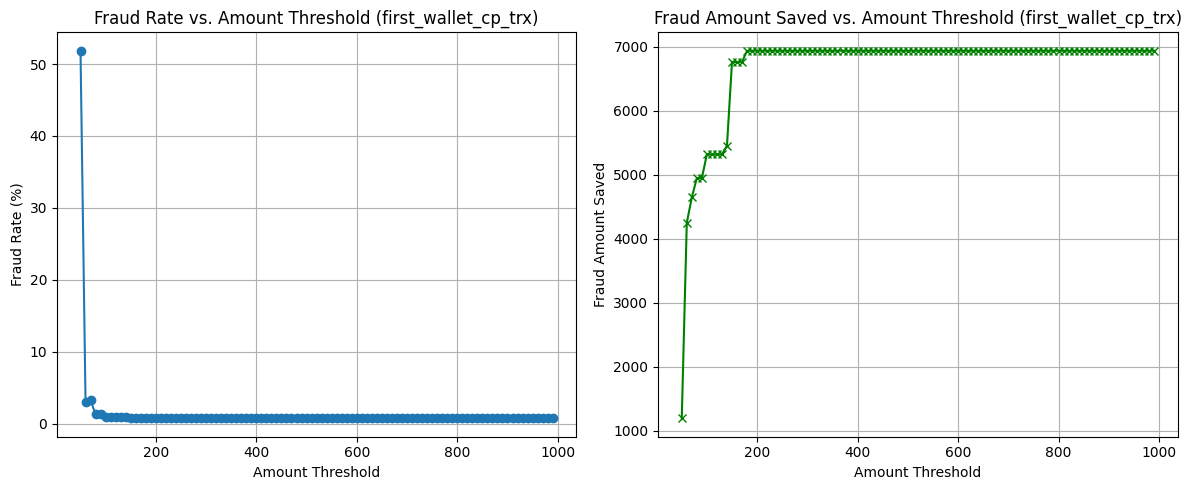

In [215]:
plot_fraud_analysis_first_wallet_trx(df, logger, "first_wallet_cp_trx", first_wallet_cp_trx)

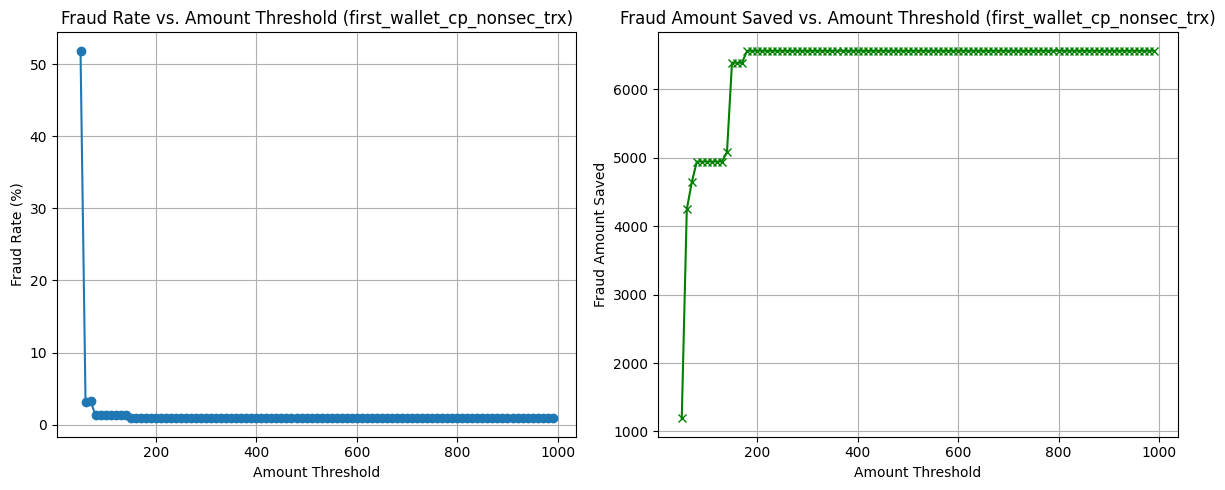

In [216]:
plot_fraud_analysis_first_wallet_trx(df, logger, "first_wallet_cp_nonsec_trx", first_wallet_cp_nonsec_trx)

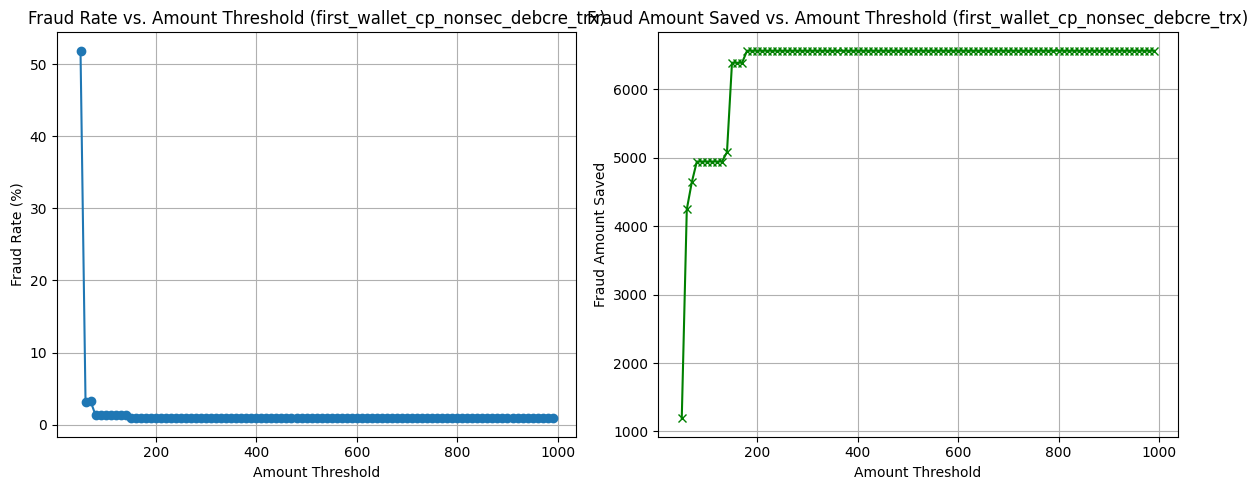

In [217]:
plot_fraud_analysis_first_wallet_trx(df, logger, "first_wallet_cp_nonsec_debcre_trx", first_wallet_cp_nonsec_debcre_trx)

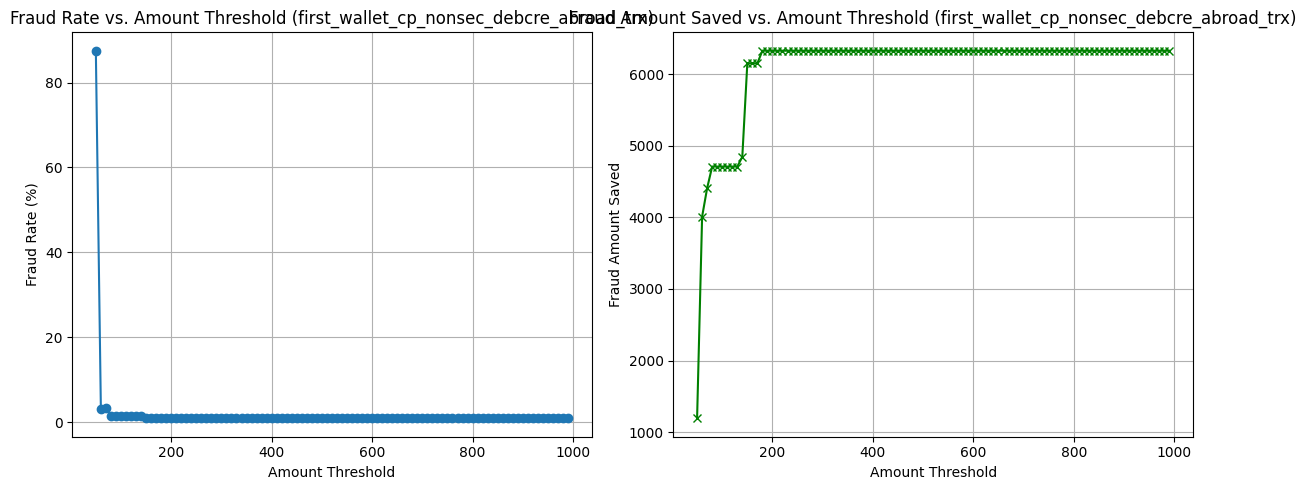

In [218]:
plot_fraud_analysis_first_wallet_trx(df, logger, "first_wallet_cp_nonsec_debcre_abroad_trx", first_wallet_cp_nonsec_debcre_abroad_trx)

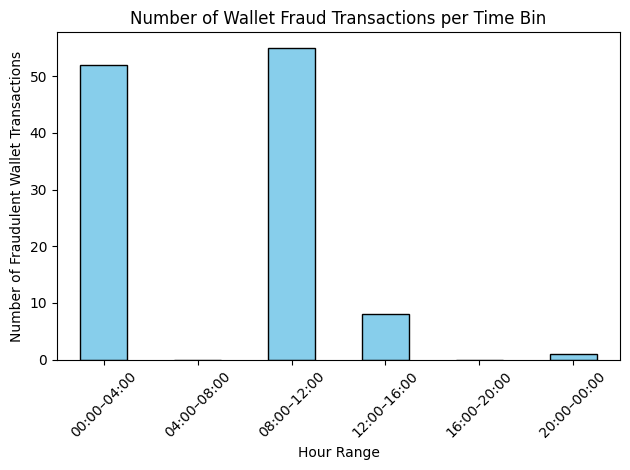

In [219]:
df_fraud_wallet = df[
    (df['fraud_label'] == 1) &
    (df['card_present'] == 1) &
    (df['number_of_wallet_trx'] == 1) &
    (df['3ds'] == 0) &
    (df['card_type'].isin(['debit', 'credit']))
].copy()

# Define bin order
bin_order = ['00:00–04:00', '04:00–08:00', '08:00–12:00',
             '12:00–16:00', '16:00–20:00', '20:00–00:00']

# Count per bin
wallet_fraud_counts = df_fraud_wallet['hour_range'].value_counts().reindex(bin_order).fillna(0).astype(int)

# Plot
wallet_fraud_counts.plot(kind='bar', color='skyblue', edgecolor='black')

plt.title('Number of Wallet Fraud Transactions per Time Bin')
plt.xlabel('Hour Range')
plt.ylabel('Number of Fraudulent Wallet Transactions')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [220]:
def first_wallet_cp_nonsec_debcre_hour_trx(df, amnt):
    return (
        (df['number_of_wallet_trx'] == 1) &
        (df['card_present'] == 1) &
        (df['amount'] < amnt) &
        (df['3ds'] == 0) &
        (df['card_type'].isin(['debit', 'credit'])) &
        (df['hour_range'].isin(["00:00–04:00", "08:00–12:00"]))
    )

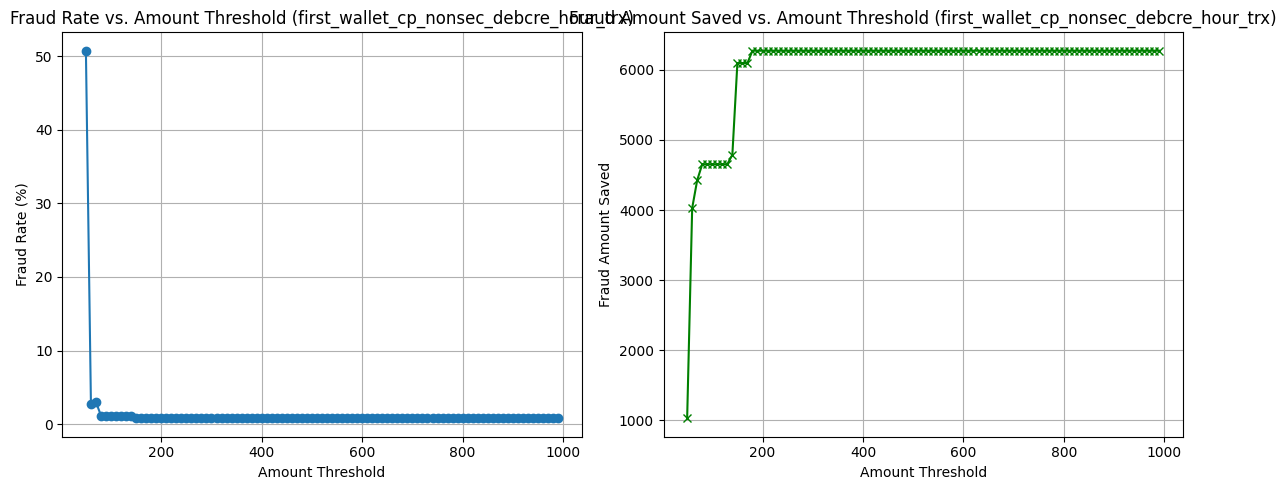

In [221]:
plot_fraud_analysis_first_wallet_trx(df, logger, "first_wallet_cp_nonsec_debcre_hour_trx", first_wallet_cp_nonsec_debcre_hour_trx)

C:\Users\HA432CU\AppData\Local\Temp\ipykernel_19052\382415162.py:6: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(
C:\Users\HA432CU\AppData\Local\Temp\ipykernel_19052\382415162.py:44: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="best", frameon=True)


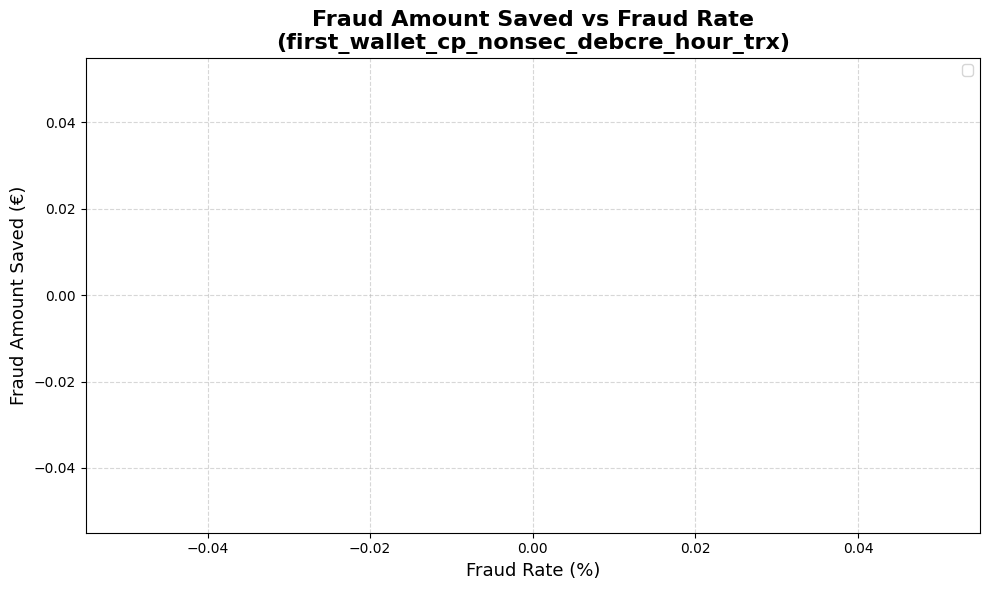

In [222]:
# Filter the DataFrame
filtered_log_df = log_df[log_df['rule_name'] == 'first_wallet_cp_nonsec_debcre_hour_trx']

# Create the scatterplot
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=filtered_log_df,
    x='fraud_rate',
    y='fraud_amount_saved',
    size='total_fraud_count',
    hue='fraud_amount_saved',
    palette='viridis',
    sizes=(40, 300),
    alpha=0.8,
    edgecolor='black',
    linewidth=0.5
)

# 
highlight = filtered_log_df[
    (filtered_log_df['fraud_rate'].between(3.0, 3.1)) &
    (filtered_log_df['fraud_amount_saved'].between(4420, 4430))
]

plt.scatter(
    highlight['fraud_rate'],
    highlight['fraud_amount_saved'],
    s=300,
    facecolors='none',
    edgecolors='red',
    linewidths=2,
)

# Optional annotation
for _, row in highlight.iterrows():
    plt.text(row['fraud_rate'] + 0.002, row['fraud_amount_saved'] + 500,
             f"Trial {row['trial_number']}", fontsize=10, color='red')

# Improve axes and title
plt.title("Fraud Amount Saved vs Fraud Rate\n(first_wallet_cp_nonsec_debcre_hour_trx)", fontsize=16, weight='bold')
plt.xlabel("Fraud Rate (%)", fontsize=13)
plt.ylabel("Fraud Amount Saved (€)", fontsize=13)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(loc="best", frameon=True)
plt.tight_layout()
plt.show()



The highlighted point in the graph showcases the best combination of thresholds. 

For this specific rule i.e. __first_wallet_cp_nonsec_debcre_hour_trx__ the thresholds chosen are the following:

- __card_present__ = 1 &
- __Amount < 70EUR__ &
- __number_of_wallet_trx = 1__ &
- __3ds = 0__ &
- __card_type is either debit or credit__ &
- __hour_range is ether 00:00-04:00 or 08:00-12:00__

When choosing these thresholds we get the following results:
1. Number of perimeter transactions -> 3091
2. Total frauds inside the perimeter -> 93
3. Fraud Rate -> 3.01%
4. Fraud Amount -> 4425EUR

In [223]:
df['first_wallet_cp_nonsec_debcre_hour_trx'] = np.where(
    (df['card_present'] == 1) &
    (df['number_of_wallet_trx'] == 1) &
    (df['amount'] < 70) &
    (df['3ds'] == 0) &
    (df['card_type'].isin(['debit', 'credit'])) &
    (df['hour_range'].isin(["00:00–04:00", "08:00–12:00"])),
    1,
    0
)

In [224]:
# Define the alert condition
alert_condition = (
    (df['card_present'] == 1) &
    (df['number_of_wallet_trx'] == 1) &
    (df['amount'] < 70) &
    (df['3ds'] == 0) &
    (df['card_type'].isin(['debit', 'credit'])) &
    (df['hour_range'].isin(["00:00–04:00", "08:00–12:00"]))
)

# Confusion Matrix Components
tps_of_first_trx_abroad_nonsec_ecom = df[alert_condition & (df['fraud_label'] == 1)].shape[0]
fps_of_first_trx_abroad_nonsec_ecom = df[alert_condition & (df['fraud_label'] == 0)].shape[0]
fns_of_first_trx_abroad_nonsec_ecom = df[~alert_condition & (df['fraud_label'] == 1)].shape[0]
tns_of_first_trx_abroad_nonsec_ecom = df[~alert_condition & (df['fraud_label'] == 0)].shape[0]

# Optional: Print nicely
print("Confusion Matrix for Rule-Based Alert:")
print(f"TP: {tps_of_first_trx_abroad_nonsec_ecom}")
print(f"FP: {fps_of_first_trx_abroad_nonsec_ecom}")
print(f"FN: {fns_of_first_trx_abroad_nonsec_ecom}")
print(f"TN: {tns_of_first_trx_abroad_nonsec_ecom}\n")

Confusion Matrix for Rule-Based Alert:
TP: 93
FP: 2998
FN: 330
TN: 131139



|confusion Matrix|Value|
|----------------|-----|
|TP|93|
|FP|2998|
|FN|330|
|TN|131139|

__We wil follow a very simillar procedure to capture CnP wallet fraudulent transactions:__

The first wallet total fraud amount is: 6738.76. The total fraud cases are: 78 and the avg fraud amount is 86.39

In [225]:
def first_wallet_cnp_trx(df, amnt):
    return ((df['number_of_wallet_trx'] == 1) & (df['card_present'] == 0) & (df['amount'] < amnt))

def first_wallet_cnp_nonsec_trx(df, amnt):
    return (
        (df['number_of_wallet_trx'] == 1) &
        (df['card_present'] == 0) &
        (df['amount'] < amnt) &
        (df['3ds'] == 0)
    )

def first_wallet_cnp_nonsec_debcre_trx(df, amnt):
    return (
        (df['number_of_wallet_trx'] == 1) &
        (df['card_present'] == 0) &
        (df['amount'] < amnt) &
        (df['3ds'] == 0) &
        (df['card_type'].isin(['debit', 'credit']))
    )


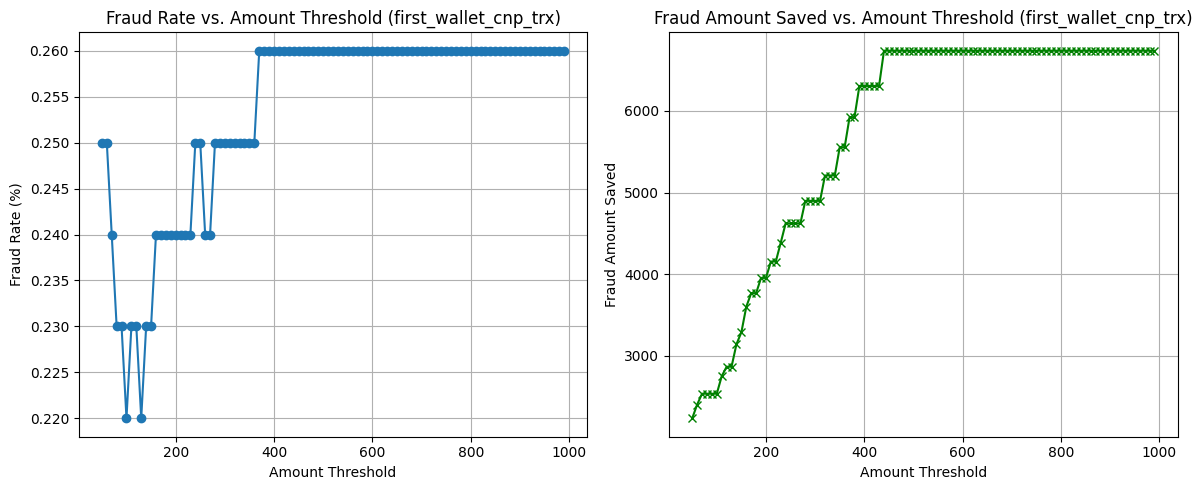

In [226]:
plot_fraud_analysis_first_wallet_trx(df, logger, "first_wallet_cnp_trx", first_wallet_cnp_trx)

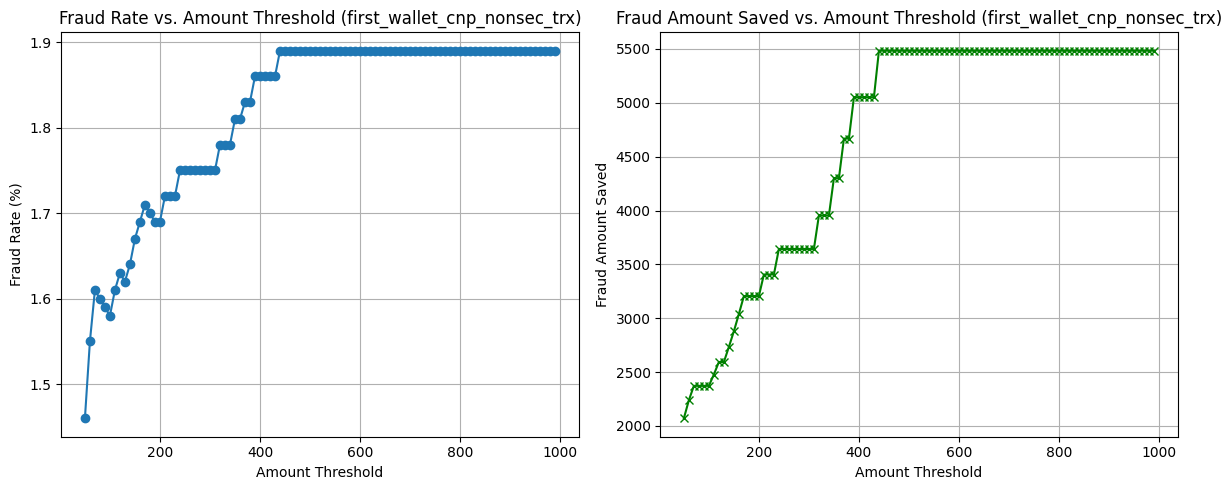

In [227]:
plot_fraud_analysis_first_wallet_trx(df, logger, "first_wallet_cnp_nonsec_trx", first_wallet_cnp_nonsec_trx)

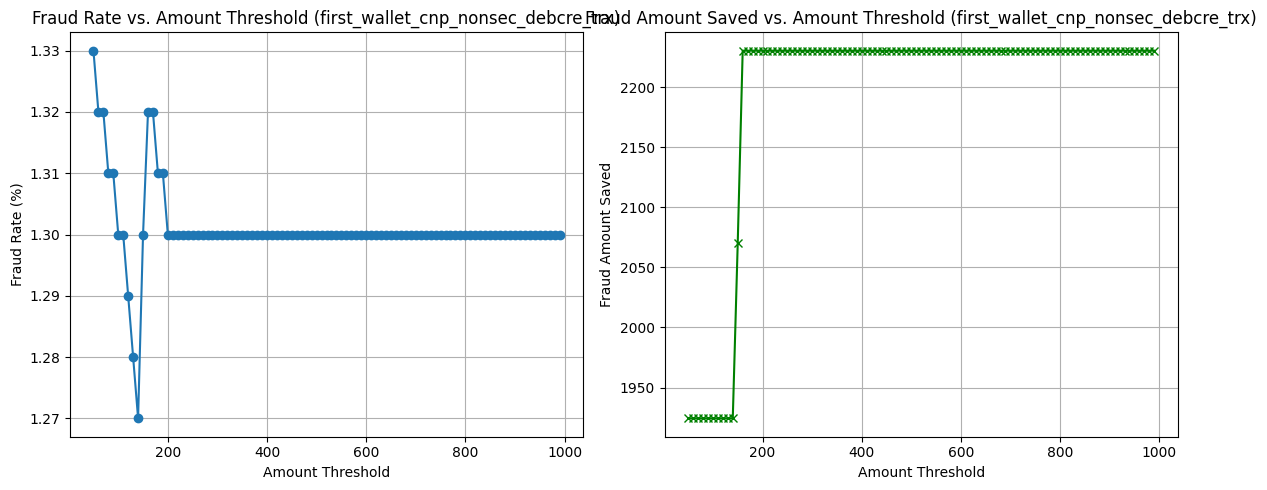

In [228]:
plot_fraud_analysis_first_wallet_trx(df, logger, "first_wallet_cnp_nonsec_debcre_trx", first_wallet_cnp_nonsec_debcre_trx)

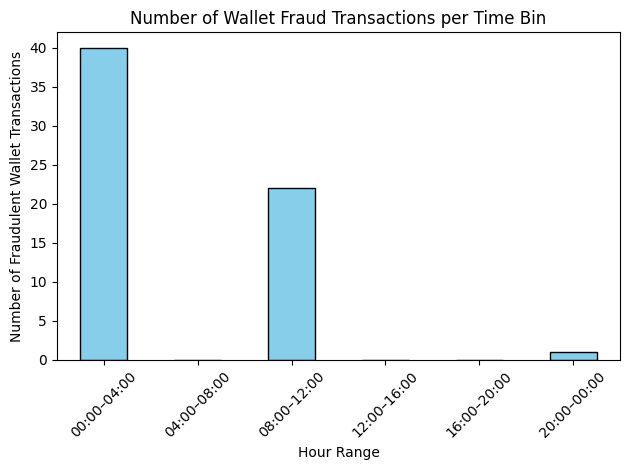

In [229]:
df_fraud_wallet = df[
    (df['fraud_label'] == 1) &
    (df['card_present'] == 0) &
    (df['number_of_wallet_trx'] == 1) &
    (df['3ds'] == 0)
].copy()

# Define bin order
bin_order = ['00:00–04:00', '04:00–08:00', '08:00–12:00',
             '12:00–16:00', '16:00–20:00', '20:00–00:00']

# Count per bin
wallet_fraud_counts = df_fraud_wallet['hour_range'].value_counts().reindex(bin_order).fillna(0).astype(int)

# Plot
wallet_fraud_counts.plot(kind='bar', color='skyblue', edgecolor='black')

plt.title('Number of Wallet Fraud Transactions per Time Bin')
plt.xlabel('Hour Range')
plt.ylabel('Number of Fraudulent Wallet Transactions')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [230]:
def first_wallet_cnp_nonsec_hour_trx(df, amnt):
    return (
        (df['number_of_wallet_trx'] == 1) &
        (df['card_present'] == 0) &
        (df['amount'] < amnt) &
        (df['3ds'] == 0) &
        (df['hour_range'].isin(["00:00–04:00", "08:00–12:00"]))
    )

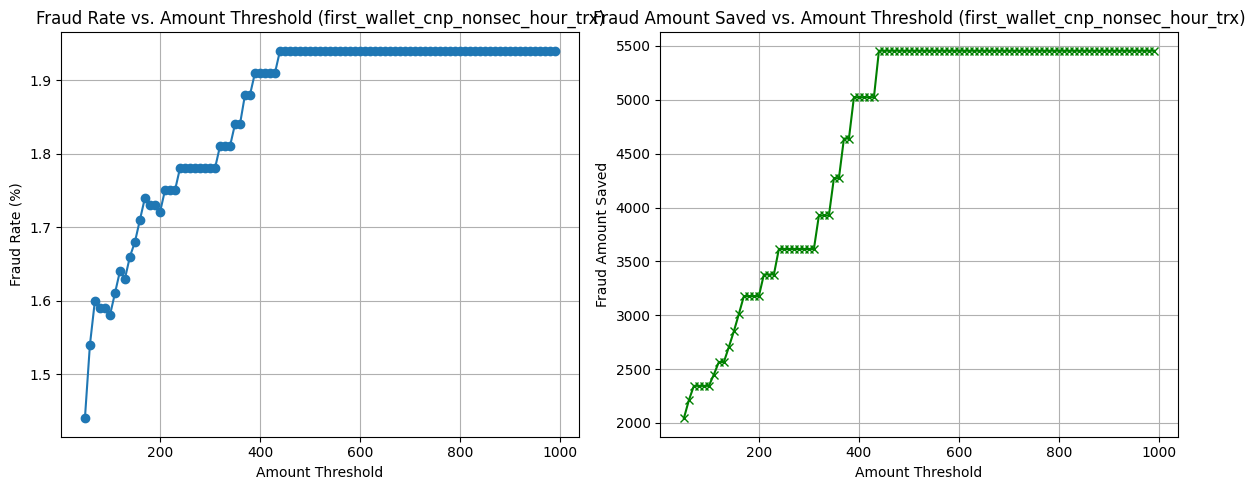

In [231]:
plot_fraud_analysis_first_wallet_trx(df, logger, "first_wallet_cnp_nonsec_hour_trx", first_wallet_cnp_nonsec_hour_trx)

In [232]:
log_df = logger.get_logs()
results = log_df[(log_df['rule_name'].isin(['first_wallet_cnp_nonsec_hour_trx', 'first_wallet_cnp_nonsec_trx']))]

In [233]:
results

,trial_number,rule_name,total_fraud_count,total_transactions,fraud_rate,fraud_amount_saved
1710,1711,first_wallet_cnp_nonsec_trx,45,3082,1.46,2070
1711,1712,first_wallet_cnp_nonsec_trx,48,3102,1.55,2238
1712,1713,first_wallet_cnp_nonsec_trx,50,3115,1.61,2372
1713,1714,first_wallet_cnp_nonsec_trx,50,3128,1.60,2372
1714,1715,first_wallet_cnp_nonsec_trx,50,3144,1.59,2372
...,...,...,...,...,...,...
1990,1991,first_wallet_cnp_nonsec_hour_trx,62,3201,1.94,5455
1991,1992,first_wallet_cnp_nonsec_hour_trx,62,3201,1.94,5455
1992,1993,first_wallet_cnp_nonsec_hour_trx,62,3201,1.94,5455
1993,1994,first_wallet_cnp_nonsec_hour_trx,62,3201,1.94,5455


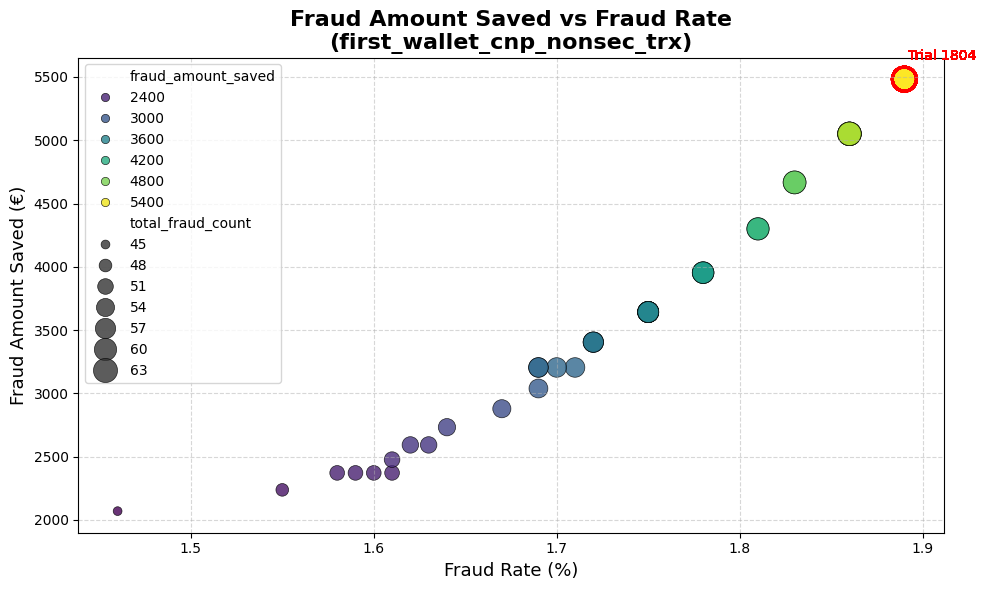

In [234]:
# Filter the DataFrame
filtered_log_df = log_df[log_df['rule_name'] == 'first_wallet_cnp_nonsec_trx']

# Create the scatterplot
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=filtered_log_df,
    x='fraud_rate',
    y='fraud_amount_saved',
    size='total_fraud_count',
    hue='fraud_amount_saved',
    palette='viridis',
    sizes=(40, 300),
    alpha=0.8,
    edgecolor='black',
    linewidth=0.5
)

# 
highlight = filtered_log_df[
    (filtered_log_df['fraud_rate'].between(1.889, 1.891)) &
    (filtered_log_df['fraud_amount_saved'].between(5482.9, 5483.1))
]

plt.scatter(
    highlight['fraud_rate'],
    highlight['fraud_amount_saved'],
    s=300,
    facecolors='none',
    edgecolors='red',
    linewidths=2,
)

# Optional annotation
for _, row in highlight.iterrows():
    plt.text(row['fraud_rate'] + 0.002, row['fraud_amount_saved'] + 150,
             "Trial 1804", fontsize=10, color='red')


# Improve axes and title
plt.title("Fraud Amount Saved vs Fraud Rate\n(first_wallet_cnp_nonsec_trx)", fontsize=16, weight='bold')
plt.xlabel("Fraud Rate (%)", fontsize=13)
plt.ylabel("Fraud Amount Saved (€)", fontsize=13)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(loc="best", frameon=True)
plt.tight_layout()
plt.show()

In [235]:
df['first_wallet_cnp_nonsec_trx'] = np.where(
    (df['card_present'] == 0) &
    (df['number_of_wallet_trx'] == 1) &
    (df['amount'] < 90) &
    (df['3ds'] == 0),
    1,
    0
)

In [236]:
# Define the alert condition
alert_condition = (
    (df['card_present'] == 0) &
    (df['number_of_wallet_trx'] == 1) &
    (df['amount'] < 90) &
    (df['3ds'] == 0)
)

# Confusion Matrix Components
tps = df[alert_condition & (df['fraud_label'] == 1)].shape[0]
fps = df[alert_condition & (df['fraud_label'] == 0)].shape[0]
fns = df[~alert_condition & (df['fraud_label'] == 1)].shape[0]
tns = df[~alert_condition & (df['fraud_label'] == 0)].shape[0]

# Optional: Print nicely
print("Confusion Matrix for Rule-Based Alert:")
print(f"TP: {tps}")
print(f"FP: {fps}")
print(f"FN: {fns}")
print(f"TN: {tns}\n")

Confusion Matrix for Rule-Based Alert:
TP: 50
FP: 3094
FN: 373
TN: 131043



|confusion Matrix|Value|
|----------------|-----|
|TP|50|
|FP|3094|
|FN|373|
|TN|131043|

### Rapid Fire Transactions

Rapid Fire Transactions are fast paced transactions that occur in a short time frame, often indicating potential fraud. 

Fraudsters usually steal physical cards or smartphones to perform multiple back to back small amount transactions.

We will use the column time_diff created during the Feature Engineering section to calculate the average time passed between two fraudulent transactions.

In [237]:
fraud_time_df = df[df['fraud_label'] == 1].copy()

average_diff = fraud_time_df['time_diff'].dropna().mean()
max_diff = fraud_time_df['time_diff'].dropna().max()
min_diff = fraud_time_df['time_diff'].dropna().min()

print("Average time difference between consecutive fraud cases:", average_diff)
print("Maximum time difference between consecutive fraud cases:", max_diff)
print("Minimum time difference between consecutive fraud cases:", min_diff)

Average time difference between consecutive fraud cases: 153.91304347826087
Maximum time difference between consecutive fraud cases: 600.0
Minimum time difference between consecutive fraud cases: 60.0


In [238]:
def plot_fraud_time_diff_analysis(df, logger, rule_name, filter_condition_fn, verbose=False):
    amounts = []
    fraud_rates = []
    fraud_savings = []

    for amnt in range(0, 1000, 10):
        condition = filter_condition_fn(df, amnt)
        summary = evaluate_and_log_fraud_rule(
            df,
            logger,
            rule_name,
            condition,
            verbose=verbose
        )
        amounts.append(amnt)
        fraud_rates.append(summary['fraud_rate (%)'])
        fraud_savings.append(summary['fraud_amount_saved'])

    # Plotting
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(amounts, fraud_rates, marker='o', linestyle='-')
    plt.title(f"Fraud Rate vs. Amount Threshold ({rule_name})")
    plt.xlabel("Amount Threshold")
    plt.ylabel("Fraud Rate (%)")
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(amounts, fraud_savings, marker='x', linestyle='-', color='green')
    plt.title(f"Fraud Amount Saved vs. Amount Threshold ({rule_name})")
    plt.xlabel("Amount Threshold")
    plt.ylabel("Fraud Amount Saved")
    plt.grid(True)

    plt.tight_layout()
    plt.show()

In [239]:
def time_diff_3_cp_analysis(df, amnt):
    return ((df['time_diff'] < 180) & (df['card_present'] == 1) & (df['amount'] < amnt))

def time_diff_3_cnp_analysis(df, amnt):
    return ((df['time_diff'] < 180) & (df['card_present'] == 0) & (df['amount'] < amnt))

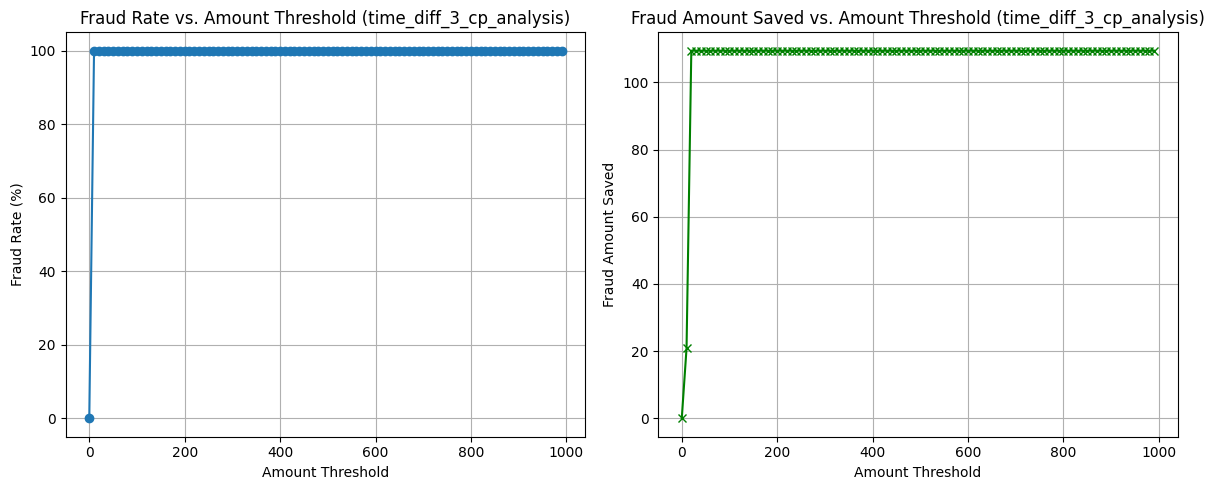

In [240]:
plot_fraud_time_diff_analysis(df, logger, "time_diff_3_cp_analysis", time_diff_3_cp_analysis)

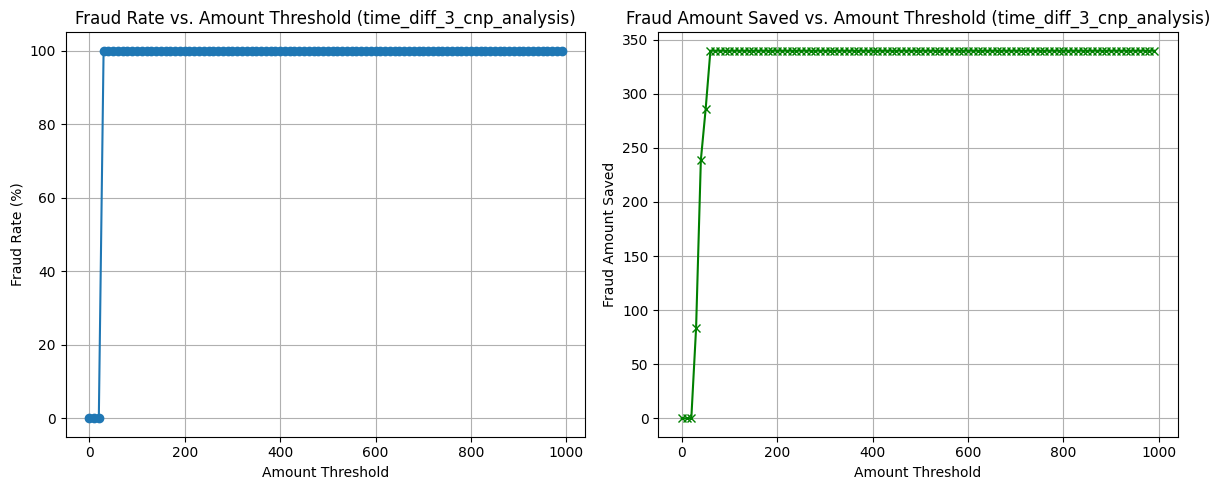

In [241]:
plot_fraud_time_diff_analysis(df, logger, "time_diff_3_cnp_analysis", time_diff_3_cnp_analysis)

In [242]:
log_df = logger.get_logs()
results = log_df[(log_df['rule_name'] == 'time_diff_3_cp_analysis')]
results

,trial_number,rule_name,total_fraud_count,total_transactions,fraud_rate,fraud_amount_saved
1995,1996,time_diff_3_cp_analysis,0,0,0.0,0
1996,1997,time_diff_3_cp_analysis,3,3,100.0,20
1997,1998,time_diff_3_cp_analysis,9,9,100.0,109
1998,1999,time_diff_3_cp_analysis,9,9,100.0,109
1999,2000,time_diff_3_cp_analysis,9,9,100.0,109
...,...,...,...,...,...,...
2090,2091,time_diff_3_cp_analysis,9,9,100.0,109
2091,2092,time_diff_3_cp_analysis,9,9,100.0,109
2092,2093,time_diff_3_cp_analysis,9,9,100.0,109
2093,2094,time_diff_3_cp_analysis,9,9,100.0,109


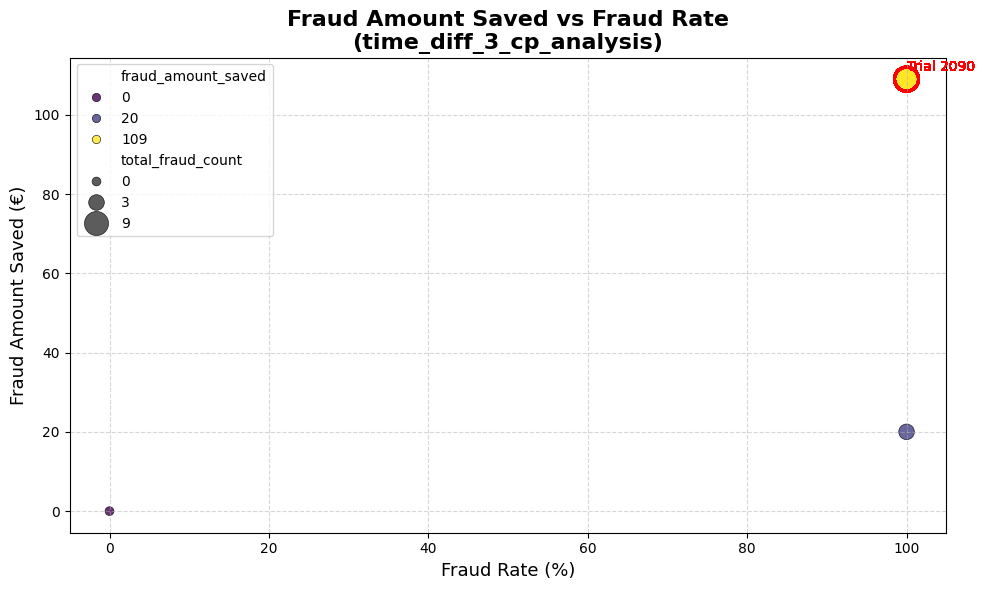

In [243]:
# Filter the DataFrame
filtered_log_df = log_df[log_df['rule_name'] == 'time_diff_3_cp_analysis']

# Create the scatterplot
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=filtered_log_df,
    x='fraud_rate',
    y='fraud_amount_saved',
    size='total_fraud_count',
    hue='fraud_amount_saved',
    palette='viridis',
    sizes=(40, 300),
    alpha=0.8,
    edgecolor='black',
    linewidth=0.5
)

highlight = filtered_log_df[
    (filtered_log_df['fraud_rate'].between(99.99, 100.0)) &
    (filtered_log_df['fraud_amount_saved'].between(108.9, 109.1))
]

plt.scatter(
    highlight['fraud_rate'],
    highlight['fraud_amount_saved'],
    s=300,
    facecolors='none',
    edgecolors='red',
    linewidths=2,
)

# Optional annotation
for _, row in highlight.iterrows():
    plt.text(
    row['fraud_rate'] + 0.1,  # small horizontal nudge
    row['fraud_amount_saved'] + 2,  # small vertical nudge
    "Trial 2090",
    fontsize=10,
    color='red'
)


# Improve axes and title
plt.title("Fraud Amount Saved vs Fraud Rate\n(time_diff_3_cp_analysis)", fontsize=16, weight='bold')
plt.xlabel("Fraud Rate (%)", fontsize=13)
plt.ylabel("Fraud Amount Saved (€)", fontsize=13)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(loc="best", frameon=True)
plt.tight_layout()
plt.show()


In [244]:
log_df = logger.get_logs()
results = log_df[(log_df['rule_name'] == 'time_diff_3_cnp_analysis')]
results

,trial_number,rule_name,total_fraud_count,total_transactions,fraud_rate,fraud_amount_saved
2095,2096,time_diff_3_cnp_analysis,0,0,0.0,0
2096,2097,time_diff_3_cnp_analysis,0,0,0.0,0
2097,2098,time_diff_3_cnp_analysis,0,0,0.0,0
2098,2099,time_diff_3_cnp_analysis,3,3,100.0,83
2099,2100,time_diff_3_cnp_analysis,8,8,100.0,238
...,...,...,...,...,...,...
2190,2191,time_diff_3_cnp_analysis,10,10,100.0,339
2191,2192,time_diff_3_cnp_analysis,10,10,100.0,339
2192,2193,time_diff_3_cnp_analysis,10,10,100.0,339
2193,2194,time_diff_3_cnp_analysis,10,10,100.0,339


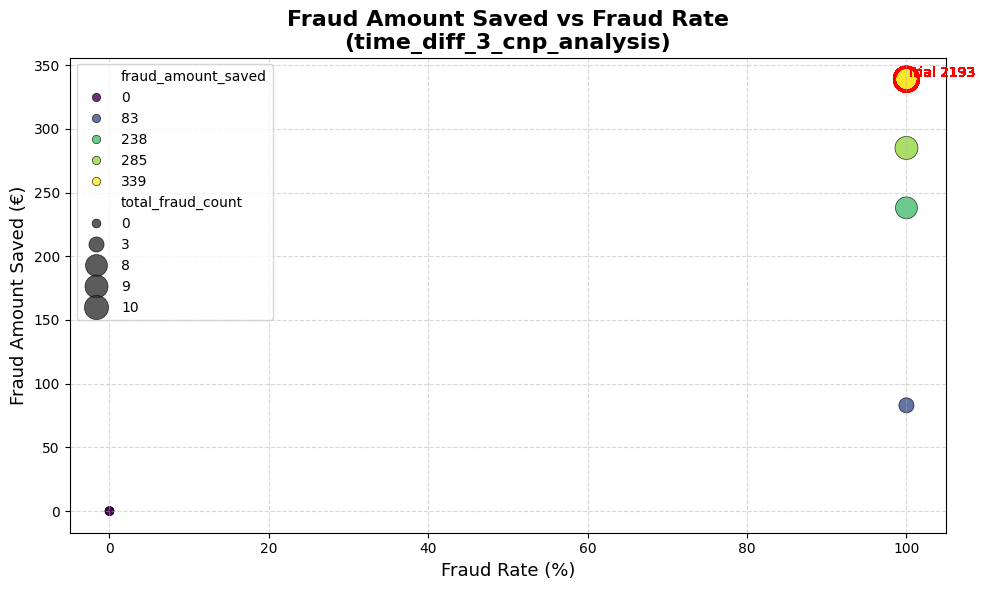

In [245]:
# Filter the DataFrame
filtered_log_df = log_df[log_df['rule_name'] == 'time_diff_3_cnp_analysis']

# Create the scatterplot
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=filtered_log_df,
    x='fraud_rate',
    y='fraud_amount_saved',
    size='total_fraud_count',
    hue='fraud_amount_saved',
    palette='viridis',
    sizes=(40, 300),
    alpha=0.8,
    edgecolor='black',
    linewidth=0.5
)

highlight = filtered_log_df[
    (filtered_log_df['fraud_rate'].between(99.99, 100.0)) &
    (filtered_log_df['fraud_amount_saved'].between(338.9, 339.1))
]

plt.scatter(
    highlight['fraud_rate'],
    highlight['fraud_amount_saved'],
    s=300,
    facecolors='none',
    edgecolors='red',
    linewidths=2,
)

# Optional annotation
# Optional annotation
for _, row in highlight.iterrows():
    plt.text(
    row['fraud_rate'] + 0.1,  # small horizontal nudge
    row['fraud_amount_saved'] + 2,  # small vertical nudge
    "Trial 2193",
    fontsize=10,
    color='red'
)

# Improve axes and title
plt.title("Fraud Amount Saved vs Fraud Rate\n(time_diff_3_cnp_analysis)", fontsize=16, weight='bold')
plt.xlabel("Fraud Rate (%)", fontsize=13)
plt.ylabel("Fraud Amount Saved (€)", fontsize=13)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(loc="best", frameon=True)
plt.tight_layout()
plt.show()


We created two very efficient rules that capture rapid fire transactions in both CP and CnP transactions.

In [246]:
df['time_diff_3_cp_analysis'] = np.where(
    (df['time_diff'] < 180) & 
    (df['card_present'] == 1) & 
    (df['amount'] < 20),
    1,
    0
)

df['time_diff_3_cnp_analysis'] = np.where(
    (df['time_diff'] < 180) & 
    (df['card_present'] == 0) & 
    (df['amount'] < 20),
    1,
    0
)

In [247]:
# Define the alert condition
alert_condition = (
    (df['time_diff'] < 180) & 
    (df['card_present'] == 1) & 
    (df['amount'] < 20)
)

# Confusion Matrix Components
tps = df[alert_condition & (df['fraud_label'] == 1)].shape[0]
fps = df[alert_condition & (df['fraud_label'] == 0)].shape[0]
fns = df[~alert_condition & (df['fraud_label'] == 1)].shape[0]
tns = df[~alert_condition & (df['fraud_label'] == 0)].shape[0]

# Optional: Print nicely
print("Confusion Matrix for Rule-Based Alert:")
print(f"TP: {tps}")
print(f"FP: {fps}")
print(f"FN: {fns}")
print(f"TN: {tns}\n")

Confusion Matrix for Rule-Based Alert:
TP: 9
FP: 0
FN: 414
TN: 134137



|confusion Matrix|Value|
|----------------|-----|
|TP|9|
|FP|0|
|FN|414|
|TN|134137|

In [248]:
# Define the alert condition
alert_condition = (
    (df['time_diff'] < 180) & 
    (df['card_present'] == 0) & 
    (df['amount'] < 40)
)

# Confusion Matrix Components
tps = df[alert_condition & (df['fraud_label'] == 1)].shape[0]
fps = df[alert_condition & (df['fraud_label'] == 0)].shape[0]
fns = df[~alert_condition & (df['fraud_label'] == 1)].shape[0]
tns = df[~alert_condition & (df['fraud_label'] == 0)].shape[0]

print("Confusion Matrix for Rule-Based Alert:")
print(f"TP: {tps}")
print(f"FP: {fps}")
print(f"FN: {fns}")
print(f"TN: {tns}\n")

Confusion Matrix for Rule-Based Alert:
TP: 8
FP: 0
FN: 415
TN: 134137



|confusion Matrix|Value|
|----------------|-----|
|TP|8|
|FP|0|
|FN|415|
|TN|134137|

### GR Transactions

Greece Transactions are dominating the total transaction population.

Specifically out of 134560 transactions, 112249(~83%) are in domestic.

We observe 29 fraud cases, where the average amount is 103.03 and the total fraud amount los tto fraud is 2987.81.

In [249]:
gr_df = df[df['country'] == 'GR']
gr_df_fraud_amount = gr_df[gr_df['fraud_label'] == 1]['amount'].sum()
gr_df_fraud_cases = gr_df[gr_df['fraud_label'] == 1].fraud_label.count()

print(f"The first wallet total fraud amount is: {round(gr_df_fraud_amount,2)}. The total fraud cases are: {round(gr_df_fraud_cases, 2)} and the avg fraud amount is {round(gr_df_fraud_amount/gr_df_fraud_cases,2)}")

The first wallet total fraud amount is: 2987.81. The total fraud cases are: 29 and the avg fraud amount is 103.03


We will perform a country specific analysis to determine rules that could be applied to to detect fraud.

We will start by examining the GR Fraud cases where the transaction is ecommerce.

In [250]:
gr_ecommerce_df = gr_df[(gr_df['ecommerce'] == 1)]
gr_ecommerce_df_fraud_amount = gr_ecommerce_df[gr_ecommerce_df['fraud_label'] == 1]['amount'].sum()
gr_ecommerce_fraud_cases = gr_ecommerce_df[gr_ecommerce_df['fraud_label'] == 1].fraud_label.count()
print(f"The GR ecommerce total fraud amount is: {round(gr_ecommerce_df_fraud_amount,2)}. The total fraud cases are: {round(gr_ecommerce_fraud_cases, 2)} and the avg fraud amount is {round(gr_ecommerce_df_fraud_amount/gr_ecommerce_fraud_cases,2)}")

The GR ecommerce total fraud amount is: 2195.04. The total fraud cases are: 20 and the avg fraud amount is 109.75


Out of 2987EUR, 2195EUR are in ecommerce fraud transactions.

These ~2200EUR are split between 20 fraud cases which is more than two thirds of the fraud cases.

We will focus mainly in ecommerce transactions to capture the most fraud amount and fraud cases.

Also it seems that the average fraud amount for an ecommerce fraudulent transaction is ~110EUR.

In [251]:
def plot_fraud_gr_analysis(df, logger, rule_name, filter_condition_fn, verbose=False):
    amounts = []
    fraud_rates = []
    fraud_savings = []

    for amnt in range(0, 1000, 10):
        condition = filter_condition_fn(df, amnt)
        summary = evaluate_and_log_fraud_rule(
            df,
            logger,
            rule_name,
            condition,
            verbose=verbose
        )
        amounts.append(amnt)
        fraud_rates.append(summary['fraud_rate (%)'])
        fraud_savings.append(summary['fraud_amount_saved'])

    # Plotting
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(amounts, fraud_rates, marker='o', linestyle='-')
    plt.title(f"Fraud Rate vs. Amount Threshold ({rule_name})")
    plt.xlabel("Amount Threshold")
    plt.ylabel("Fraud Rate (%)")
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(amounts, fraud_savings, marker='x', linestyle='-', color='green')
    plt.title(f"Fraud Amount Saved vs. Amount Threshold ({rule_name})")
    plt.xlabel("Amount Threshold")
    plt.ylabel("Fraud Amount Saved")
    plt.grid(True)

    plt.tight_layout()
    plt.show()

In [252]:
def gr_ecom_nonsec_transaction(df, amnt = 0):
    return (
        (df['country'] == 'GR') &
        (df['ecommerce'] == 1) &
        (df['3ds'] == 0) &
        (df['amount'] > amnt)
    )

def gr_ecom_nonsec_wallet_transaction(df, amnt = 0):
    return (
        (df['country'] == 'GR') &
        (df['ecommerce'] == 1) &
        (df['3ds'] == 0) &
        (df['amount'] > amnt) &
        (df['is_wallet'] == 1)
    )

def gr_ecom_nonsec_nonwallet_transaction(df, amnt = 0):
    return (
        (df['country'] == 'GR') &
        (df['ecommerce'] == 1) &
        (df['3ds'] == 0) &
        (df['amount'] > amnt) &
        (df['is_wallet'] == 0)
    )

def gr_ecom_nonsec_hour_transaction(df, amnt = 0):
    return (
        (df['country'] == 'GR') &
        (df['ecommerce'] == 1) &
        (df['3ds'] == 0) &
        (df['amount'] > amnt) &
        (df['hour_range'].isin(["00:00–04:00", "08:00–12:00"]))
    )


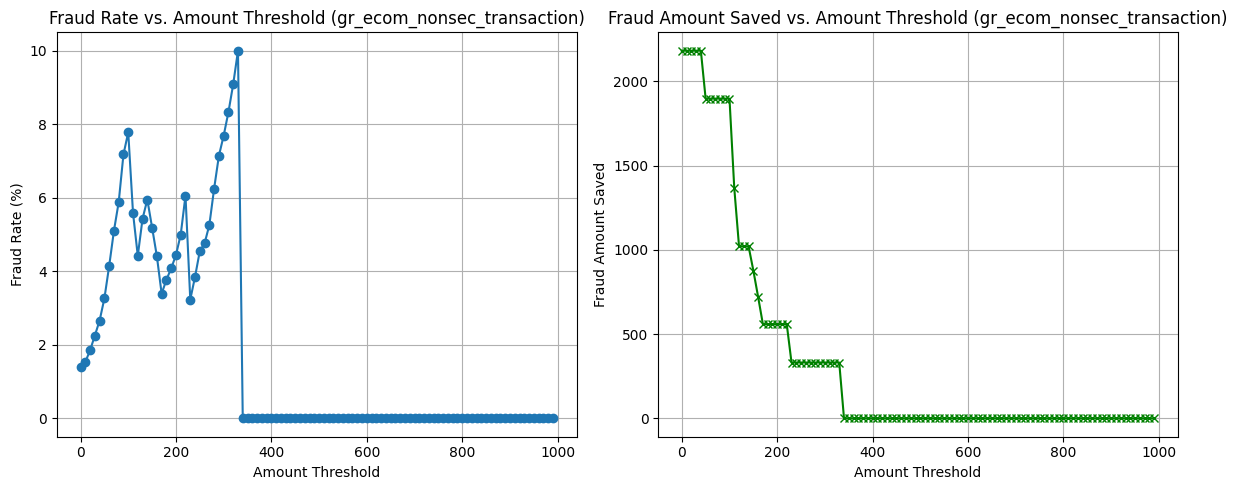

In [253]:
plot_fraud_gr_analysis(df, logger, "gr_ecom_nonsec_transaction", gr_ecom_nonsec_transaction)

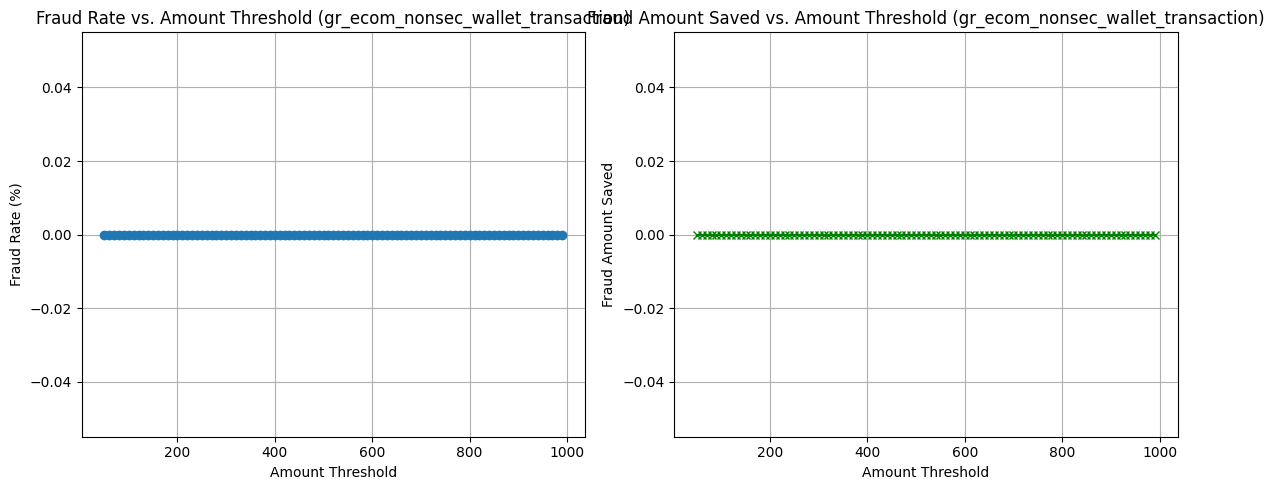

In [254]:
plot_fraud_analysis_first_wallet_trx(df, logger, "gr_ecom_nonsec_wallet_transaction", gr_ecom_nonsec_wallet_transaction)

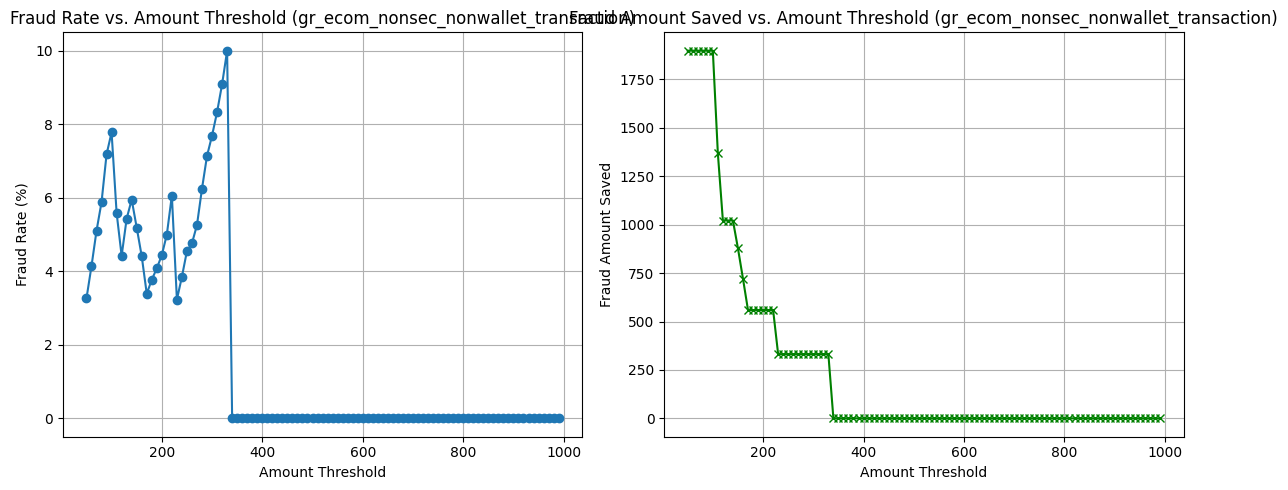

In [255]:
plot_fraud_analysis_first_wallet_trx(df, logger, "gr_ecom_nonsec_nonwallet_transaction", gr_ecom_nonsec_nonwallet_transaction)

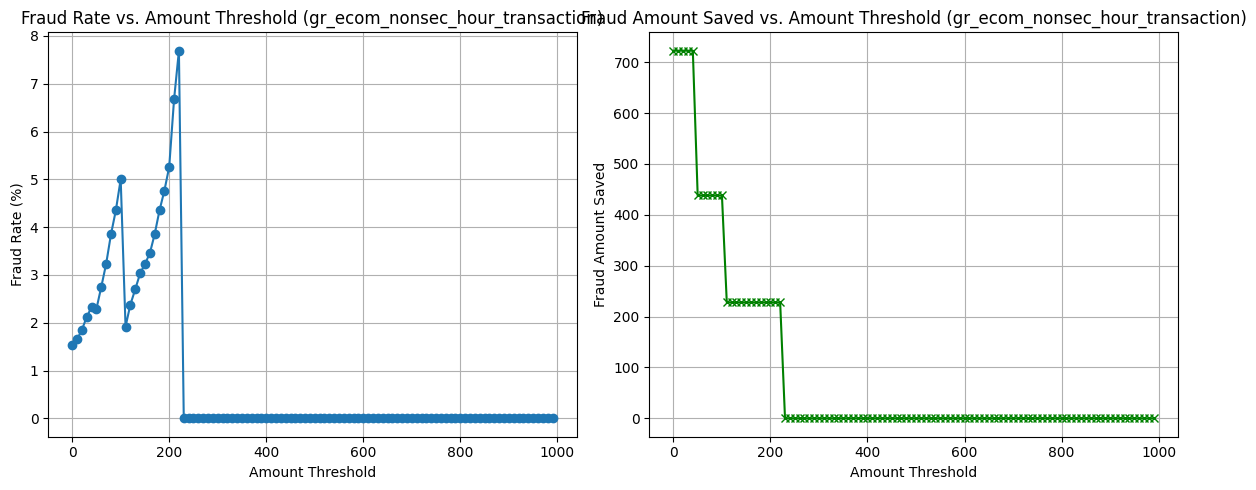

In [256]:
plot_fraud_gr_analysis(df, logger, "gr_ecom_nonsec_hour_transaction", gr_ecom_nonsec_hour_transaction)

In [257]:
log_df = logger.get_logs()
results = log_df[(log_df['fraud_amount_saved'] > 1500) & (log_df['rule_name'] == 'gr_ecom_nonsec_transaction')]

In [258]:
results

,trial_number,rule_name,total_fraud_count,total_transactions,fraud_rate,fraud_amount_saved
2195,2196,gr_ecom_nonsec_transaction,19,1369,1.39,2182
2196,2197,gr_ecom_nonsec_transaction,19,1239,1.53,2182
2197,2198,gr_ecom_nonsec_transaction,19,1025,1.85,2182
2198,2199,gr_ecom_nonsec_transaction,19,843,2.25,2182
2199,2200,gr_ecom_nonsec_transaction,19,714,2.66,2182
2200,2201,gr_ecom_nonsec_transaction,13,399,3.26,1898
2201,2202,gr_ecom_nonsec_transaction,13,314,4.14,1898
2202,2203,gr_ecom_nonsec_transaction,13,255,5.10,1898
2203,2204,gr_ecom_nonsec_transaction,13,221,5.88,1898
2204,2205,gr_ecom_nonsec_transaction,13,181,7.18,1898


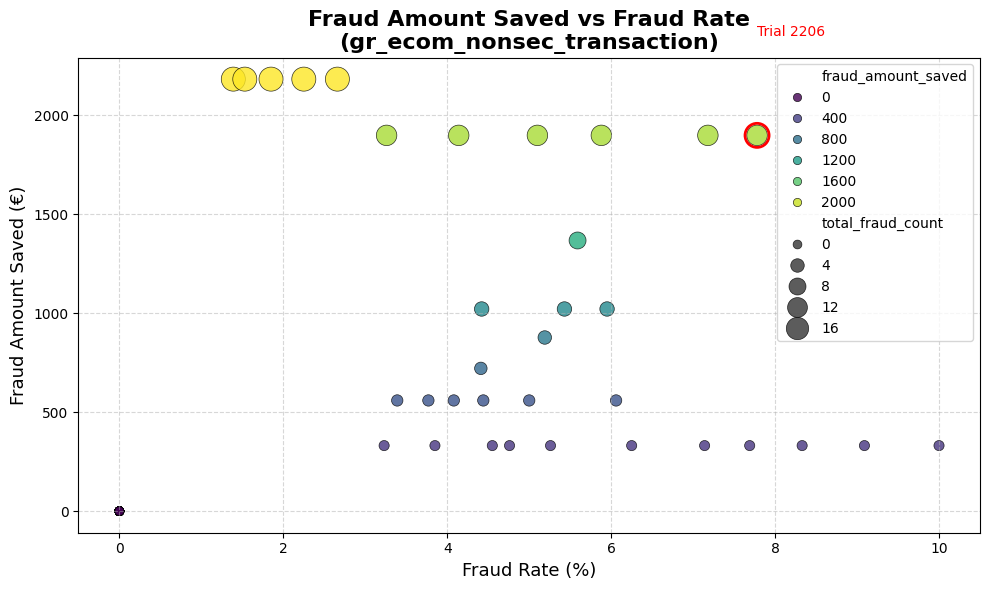

In [259]:
# Filter the DataFrame
filtered_log_df = log_df[log_df['rule_name'] == 'gr_ecom_nonsec_transaction']

# Create the scatterplot
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=filtered_log_df,
    x='fraud_rate',
    y='fraud_amount_saved',
    size='total_fraud_count',
    hue='fraud_amount_saved',
    palette='viridis',
    sizes=(40, 300),
    alpha=0.8,
    edgecolor='black',
    linewidth=0.5
)

highlight = filtered_log_df[
    (filtered_log_df['fraud_rate'].between(7.77, 7.78)) &
    (filtered_log_df['fraud_amount_saved'].between(1897.99,1898.01))
]

plt.scatter(
    highlight['fraud_rate'],
    highlight['fraud_amount_saved'],
    s=300,
    facecolors='none',
    edgecolors='red',
    linewidths=2,
)

# Optional annotation
for _, row in highlight.iterrows():
    plt.text(row['fraud_rate'] + 0.002, row['fraud_amount_saved'] + 500,
             f"Trial {row['trial_number']}", fontsize=10, color='red')

# Improve axes and title
plt.title("Fraud Amount Saved vs Fraud Rate\n(gr_ecom_nonsec_transaction)", fontsize=16, weight='bold')
plt.xlabel("Fraud Rate (%)", fontsize=13)
plt.ylabel("Fraud Amount Saved (€)", fontsize=13)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(loc="best", frameon=True)
plt.tight_layout()
plt.show()


In this particular Ecommerce Greece transaction we noticed a dangerous pattern.

Fraudulent transaction occur when a transaction has the following characteristics:

1. The customer makes an ecommerce transaction
2. The customer makes a transaction north of 100EUR
3. The transaction is non secure with a deactivated 3ds

The above should produce an alert inside the banks system for further transaction evaluation.
Adding wallet or certain time ranges of transaction add no benefit to the rule.

In [260]:
df['gr_ecom_nonsec_transaction'] = np.where(
    (df['country'] == 'GR') &
    (df['ecommerce'] == 1) &
    (df['3ds'] == 0) &
    (df['amount'] > 100),
    1,
    0
)

In [261]:
# Define the alert condition
alert_condition = (
    (df['country'] == 'GR') &
    (df['ecommerce'] == 1) &
    (df['3ds'] == 0) &
    (df['amount'] > 100)
)

# Confusion Matrix Components
tps = df[alert_condition & (df['fraud_label'] == 1)].shape[0]
fps = df[alert_condition & (df['fraud_label'] == 0)].shape[0]
fns = df[~alert_condition & (df['fraud_label'] == 1)].shape[0]
tns = df[~alert_condition & (df['fraud_label'] == 0)].shape[0]

print("Confusion Matrix for Rule-Based Alert:")
print(f"TP: {tps}")
print(f"FP: {fps}")
print(f"FN: {fns}")
print(f"TN: {tns}\n")

Confusion Matrix for Rule-Based Alert:
TP: 13
FP: 154
FN: 410
TN: 133983



|confusion Matrix|Value|
|----------------|-----|
|TP|13|
|FP|154|
|FN|410|
|TN|133983|

__GR Card Present Transactions:__

We will further our analysis by adding Card Present Fradulent transations.

In [262]:
gr_cp_df = gr_df[(gr_df['card_present'] == 1)]
gr_cp_df_fraud_amount = gr_cp_df[gr_cp_df['fraud_label'] == 1]['amount'].sum()
gr_cp_fraud_cases = gr_cp_df[gr_cp_df['fraud_label'] == 1].fraud_label.count()
print(f"The GR cp total fraud amount is: {round(gr_cp_df_fraud_amount,2)}. The total fraud cases are: {round(gr_cp_fraud_cases, 2)} and the avg fraud amount is {round(gr_cp_df_fraud_amount/gr_cp_fraud_cases,2)}")

The GR cp total fraud amount is: 792.77. The total fraud cases are: 9 and the avg fraud amount is 88.09


In [263]:
def gr_cp_nonsec_transaction(df, amnt = 0):
    return (
        (df['country'] == 'GR') &
        (df['card_present'] == 1) &
        (df['3ds'] == 0) &
        (df['amount'] > amnt)
    )

def gr_cp_nonsec_wallet_transaction(df, amnt = 0):
    return (
        (df['country'] == 'GR') &
        (df['card_present'] == 1) &
        (df['3ds'] == 0) &
        (df['amount'] > amnt) &
        (df['is_wallet'] == 1)
    )

def gr_cp_nonsec_nonwallet_transaction(df, amnt = 0):
    return (
        (df['country'] == 'GR') &
        (df['card_present'] == 1) &
        (df['3ds'] == 0) &
        (df['amount'] > amnt) &
        (df['is_wallet'] == 0)
    )

def gr_cp_nonsec_hour_transaction(df, amnt = 0):
    return (
        (df['country'] == 'GR') &
        (df['card_present'] == 1) &
        (df['3ds'] == 0) &
        (df['amount'] > amnt) &
        (df['hour_range'].isin(["08:00–12:00"]))
    )

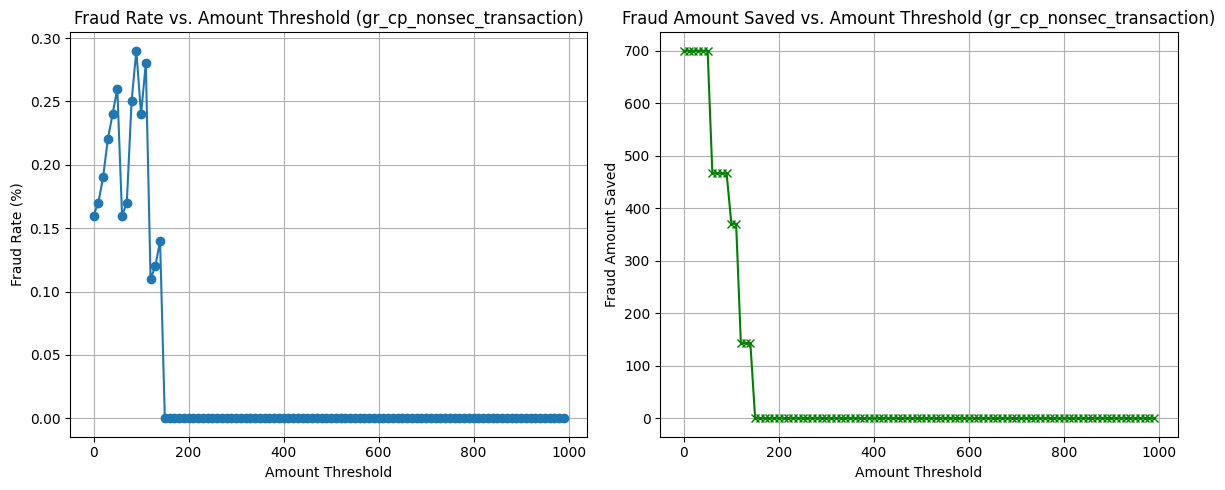

In [264]:
plot_fraud_gr_analysis(df, logger, "gr_cp_nonsec_transaction", gr_cp_nonsec_transaction)

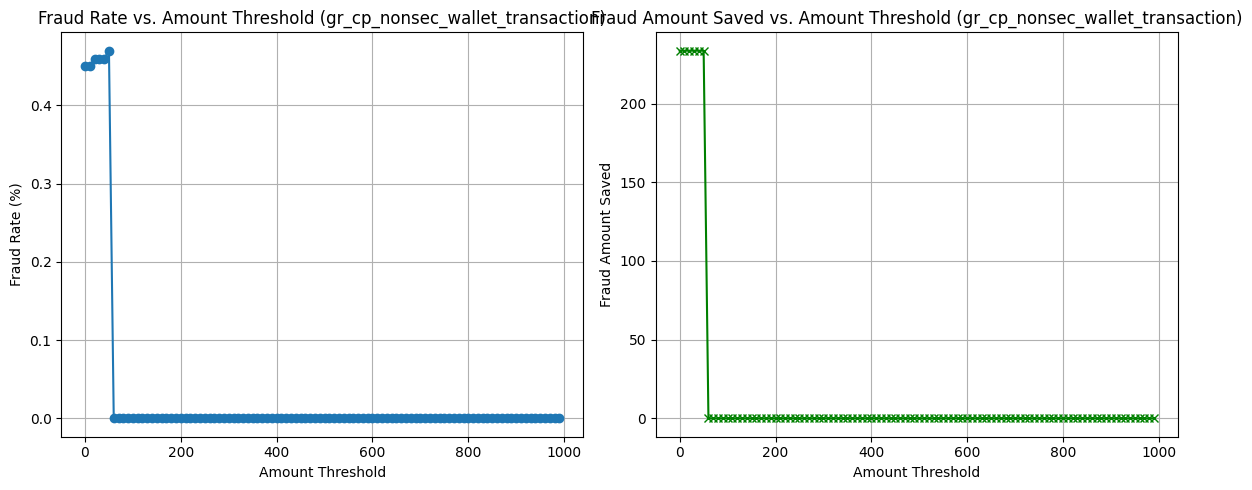

In [265]:
plot_fraud_gr_analysis(df, logger, "gr_cp_nonsec_wallet_transaction", gr_cp_nonsec_wallet_transaction)

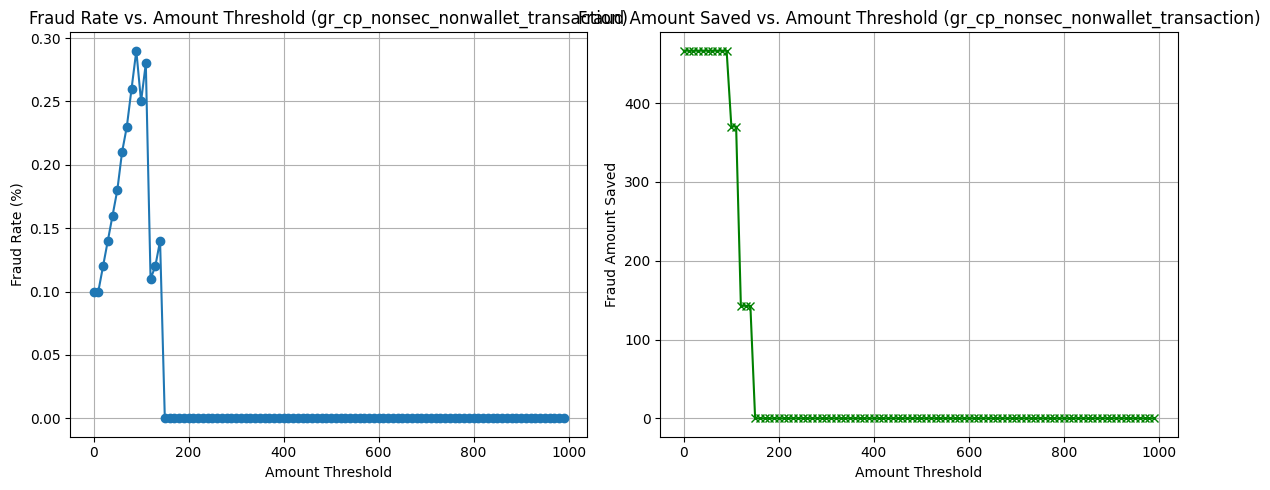

In [266]:
plot_fraud_gr_analysis(df, logger, "gr_cp_nonsec_nonwallet_transaction", gr_cp_nonsec_nonwallet_transaction)

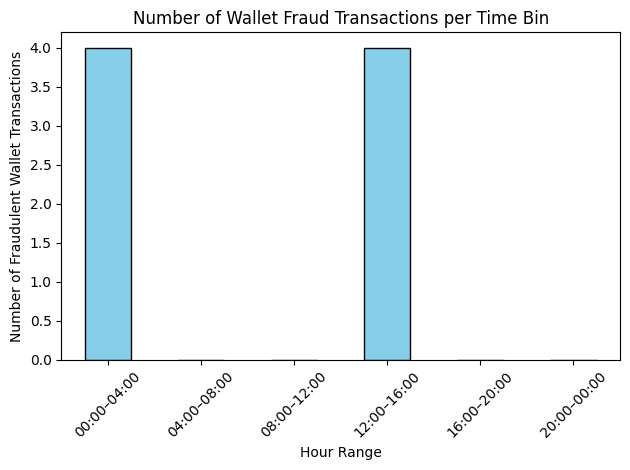

In [267]:
df_gr_cp_ = df[
    (df['fraud_label'] == 1) &
    (df['country'] == 'GR') &
    (df['card_present'] == 1) &
    (df['3ds'] == 0) 
].copy()

# Define bin order
bin_order = ['00:00–04:00', '04:00–08:00', '08:00–12:00',
             '12:00–16:00', '16:00–20:00', '20:00–00:00']

# Count per bin
wallet_fraud_counts = df_gr_cp_['hour_range'].value_counts().reindex(bin_order).fillna(0).astype(int)

# Plot
wallet_fraud_counts.plot(kind='bar', color='skyblue', edgecolor='black')

plt.title('Number of Wallet Fraud Transactions per Time Bin')
plt.xlabel('Hour Range')
plt.ylabel('Number of Fraudulent Wallet Transactions')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [268]:
def gr_cp_nonsec_nonwallet_hour_transaction(df, amnt = 0):
    return (
        (df['country'] == 'GR') &
        (df['card_present'] == 1) &
        (df['3ds'] == 0) &
        (df['amount'] > amnt) &
        (df['is_wallet'] == 0) &
        (df['hour_range'].isin(["00:00–04:00", "12:00–16:00"]))
    )

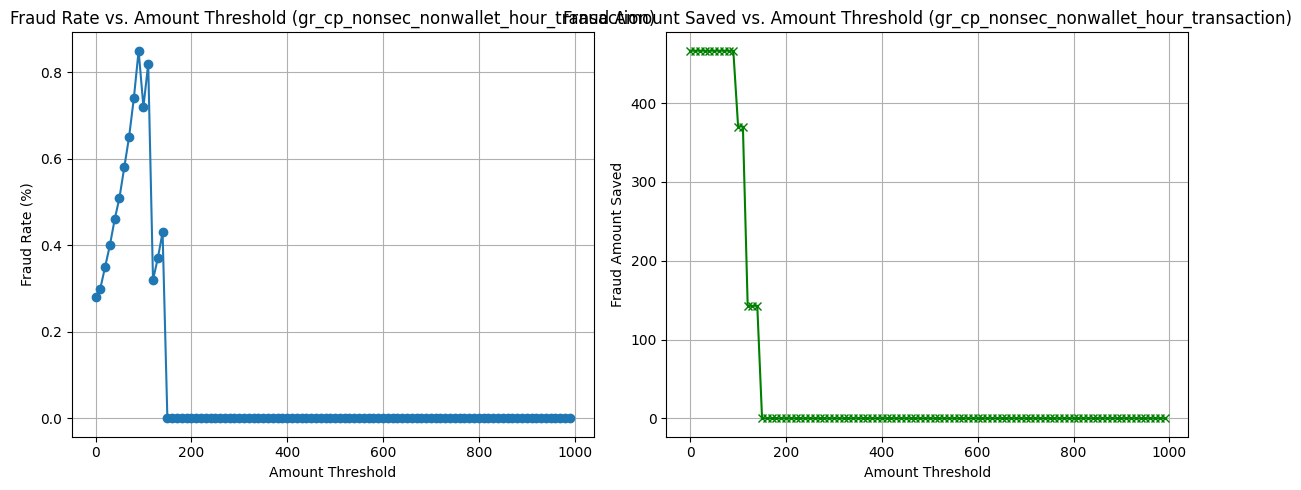

In [269]:
plot_fraud_gr_analysis(df, logger, "gr_cp_nonsec_nonwallet_hour_transaction", gr_cp_nonsec_nonwallet_hour_transaction)

No sufficient rule could be created for CP transactions with the current dataset in mind.

### Statistical Rules (Z-Score / Fuzzy Logic)

Ζ-Score is a statistical method used for normal distributions. 

The logic behind implementing a Z-Score outlier detection methodology is that a customer's transactions and transaction amounts usually follow a pattern close to a normal distribution.

We here will implement a Z-Score Outlier Detection methodology to detect outlier amounts. The formula we are going to apply is the following. 

**Z = (X - μ) / σ**

Where:
- X: the individual data point  
- μ: the mean of the dataset  
- σ: the standard deviation of the dataset

__IMPORTANT:__

We will apply Z-Score manually and not by using packages. The reason is that we are going to measure each new data point dynamically against all the already seen population.

For the purposes of fraud analysis, we define:
- previous_average: the average of all data points except the current data point
- previous_std: the std of all data points except the current data point

In [270]:
def calculate_z_scores(df, value_column, id_column='total_id', threshold=3):
    # Sort by id and a time-like column if available (for reproducibility)
    df = df.sort_values(by=[id_column])
    z_scores = []
    flags = []

    # Loop through each group
    for _, group in df.groupby(id_column):
        values = group[value_column].values
        current_z_scores = []
        current_flags = []

        for i in range(len(values)):
            if i == 0:
                # Not enough data to calculate z-score
                current_z_scores.append(np.nan)
                current_flags.append(0)
            else:
                prev_values = values[:i]
                prev_mean = np.mean(prev_values)
                prev_std = np.std(prev_values, ddof=0)  # population std

                # Handle zero std case
                if prev_std == 0:
                    z = 0
                else:
                    z = (values[i] - prev_mean) / prev_std

                current_z_scores.append(z)
                current_flags.append(1 if abs(z) > threshold else 0)

        z_scores.extend(current_z_scores)
        flags.extend(current_flags)

    # Assign results
    df['z_score'] = z_scores
    df['z_score_flag'] = flags
    return df


In [271]:
def monitor_zscore_thresholds(df, value_column, id_column='total_id', thresholds=[1, 2, 2.5, 3]):
    summary = []

    # Sort if needed
    df = df.sort_values(by=[id_column, 'timestamp']) if 'timestamp' in df.columns else df.sort_values(by=[id_column])

    for threshold in thresholds:
        temp_df = calculate_z_scores(df.copy(), value_column, id_column, threshold)
        counts = temp_df.groupby(id_column)['z_score_flag'].sum().reset_index()
        counts.columns = [id_column, f'flags_thresh_{threshold}']
        summary.append(counts)

    # Merge all threshold counts into one DataFrame
    from functools import reduce
    merged_summary = reduce(lambda left, right: pd.merge(left, right, on=id_column, how='outer'), summary).fillna(0)

    return merged_summary


In [272]:
thresholds_to_test = [1.5, 2, 2.5, 3, 3.5]

flag_summary = monitor_zscore_thresholds(df, value_column='amount', id_column='total_id', thresholds=thresholds_to_test)

In [273]:
total_flags = flag_summary.drop(columns='total_id').sum().astype(int)
print(total_flags)

flags_thresh_1.5    6
flags_thresh_2      5
flags_thresh_2.5    5
flags_thresh_3      4
flags_thresh_3.5    4
dtype: int64


In [274]:
# Choose the best threshold after testing
chosen_threshold = 3.0

# Re-run to calculate the final z_score_flag with the chosen threshold
df = calculate_z_scores(
    df,
    value_column='amount',
    id_column='total_id',
    threshold=chosen_threshold
)

In [275]:
df.drop(columns=['z_score'], inplace=True)  # Drop z_score if not needed

In [276]:
tps = df[(df['z_score_flag'] == 1) & (df['fraud_label'] == 1)].shape[0]
fps = df[(df['z_score_flag'] == 1) & (df['fraud_label'] == 0)].shape[0]
tns = df[(df['z_score_flag'] == 0) & (df['fraud_label'] == 0)].shape[0]
fns = df[(df['z_score_flag'] == 0) & (df['fraud_label'] == 1)].shape[0]
print("Confusion Matrix for Z-Score Based Alert:")
print(f"TP: {tps}")
print(f"FP: {fps}")
print(f"TN: {tns}")
print(f"FN: {fns}")

Confusion Matrix for Z-Score Based Alert:
TP: 5
FP: 0
TN: 134137
FN: 418


|confusion Matrix|Value|
|----------------|-----|
|TP|5|
|FP|0|
|FN|418|
|TN|134137|

#### Why Use a Threshold of 3.0?

#### 1. **Statistical Justification**
- According to the **Empirical Rule (68–95–99.7 Rule)** for normal distributions:
  - ~68% of values fall within ±1 standard deviation,
  - ~95% fall within ±2,
  - ~99.7% fall within **±3**.
- Therefore, any point **beyond ±3σ** is considered **extremely rare** (less than 0.3% chance under a normal distribution).

#### 2. **Balance of Sensitivity vs. Specificity**
- A **lower threshold (e.g., 2.0)** may catch more anomalies but will also generate many **false positives**, overwhelming fraud analysts.
- A **higher threshold (e.g., 3.5)** reduces false positives but increases the risk of **missing fraud cases**.
- **Z = 3.0** offers a **practical trade-off**: it flags only statistically extreme events while maintaining manageable alert volumes.

### Statistical Rules (IQR)

In [277]:
def calculate_iqr_flags(df, value_column, id_column='total_id', iqr_multiplier=1.5):
    df = df.sort_values(id_column)
    
    flags = []

    for _, group in df.groupby(id_column):
        values = group[value_column].values
        group_flags = []

        for i in range(len(values)):
            if i < 4:
                # Not enough data to form a stable IQR
                group_flags.append(0)
            else:
                prev_values = values[:i]
                q1 = np.percentile(prev_values, 25)
                q3 = np.percentile(prev_values, 75)
                iqr = q3 - q1
                lower_bound = q1 - iqr_multiplier * iqr
                upper_bound = q3 + iqr_multiplier * iqr

                if values[i] < lower_bound or values[i] > upper_bound:
                    group_flags.append(1)
                else:
                    group_flags.append(0)

        flags.extend(group_flags)

    df['iqr_flag'] = flags
    return df


In [278]:
def monitor_iqr_thresholds(df, value_column, id_column='total_id', multipliers=[1.0, 1.5, 2.0, 2.5, 3.0]):
    summary = []

    df = df.sort_values(id_column)

    for mult in multipliers:
        temp_df = calculate_iqr_flags(df.copy(), value_column, id_column, iqr_multiplier=mult)
        counts = temp_df.groupby(id_column)['iqr_flag'].sum().reset_index()
        counts.columns = [id_column, f'flags_iqr_{mult}']
        summary.append(counts)

    from functools import reduce
    merged_summary = reduce(lambda left, right: pd.merge(left, right, on=id_column, how='outer'), summary).fillna(0)

    return merged_summary


In [279]:
# Example usage
multipliers = [1.0, 1.5, 2.0, 2.5, 3.0]
iqr_flag_summary = monitor_iqr_thresholds(df, value_column='amount', id_column='total_id', multipliers=multipliers)

# Total flags across all IDs
total_iqr_flags = iqr_flag_summary.drop(columns='total_id').sum().astype(int)
print(total_iqr_flags)


flags_iqr_1.0    2
flags_iqr_1.5    1
flags_iqr_2.0    1
flags_iqr_2.5    1
flags_iqr_3.0    1
dtype: int64


No significant fraud can be identified by applying IQR in amount by each total_id

### Linear Regression

In [280]:
def detect_linear_regression_outliers(df, value_column='amount', id_column='total_id', time_column='datetime',
                                       slope_threshold=0.1, pvalue_threshold=0.05):
    df = df.sort_values(by=[id_column, time_column])
    lr_flags = []

    for _, group in df.groupby(id_column):
        group = group.copy()

        if len(group) < 5:
            # Not enough data to regress meaningfully
            group['lr_flag'] = 0
            lr_flags.append(group)
            continue

        # Convert datetime to ordinal (numeric) for regression
        x = group[time_column].map(pd.Timestamp.toordinal).values
        y = group[value_column].values

        # Perform linear regression
        slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)

        # Flag logic
        if p_value < pvalue_threshold and abs(slope) > slope_threshold:
            group['lr_flag'] = 1
        else:
            group['lr_flag'] = 0

        lr_flags.append(group)

    result_df = pd.concat(lr_flags, ignore_index=True)
    return result_df


In [281]:
def monitor_lr_flags(df, value_column='amount', id_column='total_id', time_column='datetime',
                     pvalue_threshold=0.05, slope_thresholds=[0.1, 0.2, 0.5, 1.0]):
    
    summaries = []

    for slope_th in slope_thresholds:
        temp_df = detect_linear_regression_outliers(df.copy(), value_column, id_column, time_column,
                                                    slope_threshold=slope_th, pvalue_threshold=pvalue_threshold)
        counts = temp_df.groupby(id_column)['lr_flag'].sum().reset_index()
        counts.columns = [id_column, f'flags_lr_slope_{slope_th}']
        summaries.append(counts)

    from functools import reduce
    merged = reduce(lambda left, right: pd.merge(left, right, on=id_column, how='outer'), summaries).fillna(0)
    return merged


In [282]:
def add_lr_flag_column(df, value_column='amount', id_column='total_id', time_column='datetime',
                       slope_threshold=0.1, pvalue_threshold=0.05, flag_column_name='lr_flag'):
    temp_df = detect_linear_regression_outliers(
        df.copy(), value_column, id_column, time_column,
        slope_threshold=slope_threshold, pvalue_threshold=pvalue_threshold
    )
    df_with_flag = df.copy()
    df_with_flag[flag_column_name] = temp_df['lr_flag']
    return df_with_flag


In [283]:
slope_thresholds_to_test = [0.1, 0.2]
lr_flag_summary = monitor_lr_flags(df, value_column='amount', id_column='total_id',
                                   time_column='datetime', slope_thresholds=slope_thresholds_to_test)

total_lr_flags = lr_flag_summary.drop(columns='total_id').sum().astype(int)
print(total_lr_flags)


flags_lr_slope_0.1    10
flags_lr_slope_0.2    10
dtype: int64


In [284]:
# Choose your slope threshold
chosen_slope_threshold = 0.2

# Add the flag to the DataFrame
df = add_lr_flag_column(
    df,
    value_column='amount',
    id_column='total_id',
    time_column='datetime',
    slope_threshold=chosen_slope_threshold,
    flag_column_name='lr_flag_0_2'  # name can reflect the threshold
)


In [285]:
df_with_lr = df[(df['lr_flag_0_2'] == 1) & (df['fraud_label'] == 1)]
df_with_lr

,drn,customer_id,masked_pan,datetime,card_present,ecommerce,3ds,wallet,country,amount,...,time_diff,first_trx_abroad_nonsec_ecom,high_risk_country_trx_nonsec_nonwallet,first_wallet_cp_nonsec_debcre_hour_trx,first_wallet_cnp_nonsec_trx,time_diff_3_cp_analysis,time_diff_3_cnp_analysis,gr_ecom_nonsec_transaction,z_score_flag,lr_flag_0_2
112055,FAKEWALLETTXN0000,CUST_FAKE001,**** **** **** 9999,2024-04-28 23:56:32,1,0,0,Apple Pay,DE,6.06,...,NaN,0,0,0,0,0,0,0,0,1
112056,FAKEWALLETTXN0001,CUST_FAKE001,**** **** **** 9999,2024-04-28 23:57:32,1,0,0,Apple Pay,DE,11.00,...,60.0,0,0,0,0,1,0,0,0,1
112057,FAKEWALLETTXN0002,CUST_FAKE001,**** **** **** 9999,2024-04-28 23:58:32,1,0,0,Apple Pay,DE,4.06,...,60.0,0,0,0,0,1,0,0,0,1
112058,FAKEWALLETTXN0003,CUST_FAKE001,**** **** **** 9999,2024-04-28 23:59:32,1,0,0,Apple Pay,DE,7.11,...,60.0,0,0,0,0,1,0,0,0,1
112059,FAKEWALLETTXN0004,CUST_FAKE001,**** **** **** 9999,2024-04-29 00:00:32,1,0,0,Apple Pay,DE,18.54,...,60.0,0,0,0,0,1,0,0,1,1
112060,FAKEWALLETTXN0005,CUST_FAKE001,**** **** **** 9999,2024-04-29 00:01:32,1,0,0,Apple Pay,DE,16.89,...,60.0,0,0,0,0,1,0,0,0,1
112061,FAKEWALLETTXN0006,CUST_FAKE001,**** **** **** 9999,2024-04-29 00:02:32,1,0,0,Apple Pay,DE,10.40,...,60.0,0,0,0,0,1,0,0,0,1
112062,FAKEWALLETTXN0007,CUST_FAKE001,**** **** **** 9999,2024-04-29 00:03:32,1,0,0,Apple Pay,DE,13.80,...,60.0,0,0,0,0,1,0,0,0,1
112063,FAKEWALLETTXN0008,CUST_FAKE001,**** **** **** 9999,2024-04-29 00:04:32,1,0,0,Apple Pay,DE,17.90,...,60.0,0,0,0,0,1,0,0,0,1
112064,FAKEWALLETTXN0009,CUST_FAKE001,**** **** **** 9999,2024-04-29 00:05:32,1,0,0,Apple Pay,DE,9.71,...,60.0,0,0,0,0,1,0,0,0,1


We applied Linear Regression in various slope thresholds and with p-value < 0.05 to catch significant upward trends and detect potential fraud. 

We did not yield any meaningful results though.

LR can be very impactful in Insight generation and could be used by fraud officers as a proactive tool to monitor underlying factors before fraud takes place.

## The Alert Generator

In the previous section we formulated rules that can assist as in our fraud detection. Each one of these rules generates an alert. That alert is the used by fraud officers.

We make the following assumption. 

__IMPORTANT__

An alert is generated if even one of our rules is triggered. We do not generate alerts equal to the number of rules triggered if a transaction triggers multiple of our rules.

In [286]:
rule_columns = ['first_trx_abroad_nonsec_ecom',
       'high_risk_country_trx_nonsec_nonwallet',
       'first_wallet_cp_nonsec_debcre_hour_trx', 
       'first_wallet_cnp_nonsec_trx',
       'time_diff_3_cp_analysis', 
       'time_diff_3_cnp_analysis',
       'gr_ecom_nonsec_transaction', 
       'z_score_flag']

df['alert'] = df[rule_columns].any(axis=1).astype(int)

In [287]:
# Define the alert condition
alert_condition = (
    df['alert'] == 1
)

# Confusion Matrix Components
tps = df[alert_condition & (df['fraud_label'] == 1)].shape[0]
fps = df[alert_condition & (df['fraud_label'] == 0)].shape[0]
fns = df[~alert_condition & (df['fraud_label'] == 1)].shape[0]
tns = df[~alert_condition & (df['fraud_label'] == 0)].shape[0]


# Optional: Print nicely
print("Confusion Matrix for Rule-Based Alert:")
print(f"TP: {tps}")
print(f"FP: {fps}")
print(f"FN: {fns}")
print(f"TN: {tns}\n")

Confusion Matrix for Rule-Based Alert:
TP: 320
FP: 9468
FN: 103
TN: 124669



|confusion Matrix|Value|
|----------------|-----|
|TP|320|
|FP|9468|
|FN|103|
|TN|124669|

__KEY PERFORMANCE INDICATORS (KPIs)__

We define the following KPIs.

- __ACR = Alert Conversion Rate -- The percentage of alerts that are actually confirmed as fraud. Measures how many alerts were true positives.__
    - __TP / (TP+FP) -- Industry benchmark: >= 2-5%__
- __FDR = Fraud Detection Rate -- The percentage of actual fraud cases that are successfully detected by the system.__
    - __TP / (TP+FN) -- Industry benchmark: >= 95% (For complete historicity and fully detailed dataset)__
- __FPR = False Positive Rate -- The percentage of legitimate transactions incorrectly flagged as fraud.__
    - __FP / (FP+TN) -- Industry benchmark: <= 1-5% (Varies according to use case -- For complete historicity and fully detailed dataset)__
- __FACR = Fraud Amount Captured Rate -- The percentage of amount captured from correctly identifying fraudulent transactions__
    - __(TP * Amount of Transaction) / ((TP + TN) * Amount of Transaction)__


In [288]:
acr = tps / (tps + fps) if (tps + fps) > 0 else 0
fdr = tps / (tps + fns) if (tps + fns) > 0 else 0
fpr = fps / (fps + tns) if (fps + tns) > 0 else 0
facr = (df[(df['alert'] == 1) & (df['fraud_label'] == 1)]['amount'].sum()) / df[df['fraud_label'] == 1]['amount'].sum()

In [289]:
print("Alert Condition Metrics:")
print(f"Alert Conversion Rate (ACR): {acr * 100:.4f}%")
print(f"Fraud Detection Rate (FDR): {fdr * 100:.4f}%")
print(f"False Positive Rate (FPR): {fpr * 100:.4f}%")
print(f"Fraud Amount Captured Rate (FACR): {facr * 100:.4f}%")

Alert Condition Metrics:
Alert Conversion Rate (ACR): 3.2693%
Fraud Detection Rate (FDR): 75.6501%
False Positive Rate (FPR): 7.0585%
Fraud Amount Captured Rate (FACR): 82.4701%


#### Fraud Detection - KPI Summary

| **KPI**                               |  **Your Value** | **Industry Benchmark**      |
|-------------------------------------  |---------------- |-----------------------------|
| **ACR** (Alert Conversion Rate)       | 3.27%           | ≥ 1–5%                      |
| **FDR** (Fraud Detection Rate)        | 75.65%          | ≥ 90–95%                    |
| **FPR** (False Positive Rate)         | 7.06%           | ≤ 1–5%                      |
| **FACR** (Fraud Amount Captured Rate) | 82.47%          | > 80% (desirable)           |


**Note:** KPIs achieved using statistical + business rules on 6 months of synthetic transaction data (~135,000 records). MCC and customer demographics are missing.


In [290]:
df.to_csv("C:\\Users\\HA432CU\\Courses\\Personal Projects\\Python\\Fraud Detection\\data\\Bank_Wallet_Transactions_Rules.csv", date_format='%Y-%m-%d %H:%M:%S', index=False)